# Στοιχεία ομάδας:
Ομάδα 99<br>
Αντωνίου Γιώργος 03117715<br>
Κυριάκου Δημήτρης 03117601<br>
Χατζηχριστοφή Χρίστος 03117711<br>

# Εργαστηριακή Άσκηση 2. Μη επιβλεπόμενη μάθηση. 
## Σύστημα συστάσεων βασισμένο στο περιεχόμενο
## Σημασιολογική απεικόνιση δεδομένων με χρήση SOM 
Ημερομηνία εκφώνησης της άσκησης: 23 Νοεμβρίου 2021

**Θα βρείτε το παρόν σε μορφή jupyter notebook ως συνημμένο στο τέλος της εκφώνησης.**


In [ ]:
!pip install --upgrade pip
!pip install --upgrade numpy
!pip install --upgrade pandas
!pip install --upgrade nltk
!pip install --upgrade scikit-learn
!pip install --upgrade joblib
!pip install -U gensim

ERROR: Operation cancelled by user


In [ ]:
import numpy as np
import pandas as pd
import nltk
import sys
import scipy as sp
from time import time 
import re
import joblib
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import PCA
import string
import collections
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader

## Εισαγωγή του Dataset

Το σύνολο δεδομένων με το οποίο θα δουλέψουμε είναι βασισμένο στο [Carnegie Mellon Movie Summary Corpus](http://www.cs.cmu.edu/~ark/personas/). Πρόκειται για ένα dataset με 22.301 περιγραφές ταινιών. Η περιγραφή κάθε ταινίας αποτελείται από τον τίτλο της, μια ή περισσότερες ετικέτες που χαρακτηρίζουν το είδος της ταινίας και τέλος τη σύνοψη της υπόθεσής της. Αρχικά εισάγουμε το dataset (χρησιμοποιήστε αυτούσιο τον κώδικα, δεν χρειάζεστε το αρχείο csv) στο dataframe `df_data_1`: 

In [ ]:
dataset_url = "https://drive.google.com/uc?export=download&id=1-tN5rC1QCgwqL67cvIXdMbtd-Xf9Xqow"
df_data_1 = pd.read_csv(dataset_url, sep = '\t',  header = None, quoting = 3)

Κάθε ομάδα θα δουλέψει σε **ένα μοναδικό υποσύνολο 5.000 ταινιών** (διαφορετικό dataset για κάθε ομάδα) ως εξής:

1. Κάθε ομάδα του εργαστηρίου νευρωνικών έχει έναν αριθμό στο helios. Θα βάλετε τον αριθμό αυτό στη μεταβλητή team_seed_number στο επόμενο κελί κώδικα.

2. Το data frame `df_data_2` έχει γραμμές όσες και οι ομάδες και 5.000 στήλες. Σε κάθε ομάδα αντιστοιχεί η γραμμή του πίνακα με το `team_seed_number` της. Η γραμμή αυτή θα περιλαμβάνει 5.000 διαφορετικούς αριθμούς που αντιστοιχούν σε ταινίες του αρχικού dataset. 

3. Τρέξτε τον κώδικα. Θα προκύψουν τα μοναδικά για κάθε ομάδα  titles, categories, catbins, summaries και corpus με τα οποία θα δουλέψετε.

In [ ]:
# Στο επόμενη γραμή βάλτε τον αριθμό της ομάδας στο εργαστήριο των νευρωνικών
team_seed_number = 99

movie_seeds_url = "https://drive.google.com/uc?export=download&id=1-oeMf7BFmiH70XObgC9WOTo-a9cDJZwP"
df_data_2 = pd.read_csv(movie_seeds_url, header = None)

# επιλέγεται 
my_index = df_data_2.iloc[team_seed_number, :].values

titles = df_data_1.iloc[:, [2]].values[my_index] # movie titles (string)
categories = df_data_1.iloc[:, [3]].values[my_index] # movie categories (string)
bins = df_data_1.iloc[:, [4]]
catbins = bins[4].str.split(',', expand = True).values.astype(float)[my_index] # movie categories in binary form (1 feature per category)
summaries = df_data_1.iloc[:, [5]].values[my_index] # movie summaries (string)
corpus = summaries[:, 0].tolist() # list form of summaries
corpus_df = pd.DataFrame(corpus) # dataframe version of corpus

- Ο πίνακας **titles** περιέχει τους τίτλους των ταινιών. Παράδειγμα: 'Sid and Nancy'.
- O πίνακας **categories** περιέχει τις κατηγορίες (είδη) της ταινίας υπό τη μορφή string. Παράδειγμα: '"Tragedy",  "Indie",  "Punk rock",  "Addiction Drama",  "Cult",  "Musical",  "Drama",  "Biopic \[feature\]",  "Romantic drama",  "Romance Film",  "Biographical film"'. Παρατηρούμε ότι είναι μια comma separated λίστα strings, με κάθε string να είναι μια κατηγορία.
- Ο πίνακας **catbins** περιλαμβάνει πάλι τις κατηγορίες των ταινιών αλλά σε δυαδική μορφή ([one hot encoding](https://hackernoon.com/what-is-one-hot-encoding-why-and-when-do-you-have-to-use-it-e3c6186d008f)). Έχει διαστάσεις 5.000 x 322 (όσες οι διαφορετικές κατηγορίες). Αν η ταινία ανήκει στο συγκεκριμένο είδος η αντίστοιχη στήλη παίρνει την τιμή 1, αλλιώς παίρνει την τιμή 0.
- Ο πίνακας **summaries** και η λίστα **corpus** περιλαμβάνουν τις συνόψεις των ταινιών (η corpus είναι απλά ο summaries σε μορφή λίστας). Κάθε σύνοψη είναι ένα (συνήθως μεγάλο) string. Παράδειγμα: *'The film is based on the real story of a Soviet Internal Troops soldier who killed his entire unit  as a result of Dedovschina. The plot unfolds mostly on board of the prisoner transport rail car guarded by a unit of paramilitary conscripts.'*
- το dataframe corpus_df που είναι απλά το corpus σε μορφή dataframe. Τα summaries βρίσκονται στην κολόνα 0. Πιθανώς να σας βολεύει να κάνετε κάποιες προεπεξεργασίες με dataframes.


Θεωρούμε ως **ID** της κάθε ταινίας τον αριθμό γραμμής της ή το αντίστοιχο στοιχείο της λίστας. Παράδειγμα: για να τυπώσουμε τη σύνοψη της ταινίας με `ID=999` (την χιλιοστή) θα γράψουμε `print(corpus[999])`.

In [ ]:
ID = 999
print(titles[ID])
print(categories[ID])
print(catbins[ID])
print(corpus[ID])

['Deewaar']
['"Action/Adventure",  "Drama",  "World cinema"']
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

# Εφαρμογή 1. Υλοποίηση συστήματος συστάσεων ταινιών βασισμένο στο περιεχόμενο
<img src="http://clture.org/wp-content/uploads/2015/12/Netflix-Streaming-End-of-Year-Posts.jpg" width="70%">

Η πρώτη εφαρμογή που θα αναπτύξετε θα είναι ένα [σύστημα συστάσεων](https://en.wikipedia.org/wiki/Recommender_system) ταινιών βασισμένο στο περιεχόμενο (content based recommender system). Τα συστήματα συστάσεων στοχεύουν στο να προτείνουν αυτόματα στο χρήστη αντικείμενα από μια συλλογή τα οποία ιδανικά θέλουμε να βρει ενδιαφέροντα ο χρήστης. Η κατηγοριοποίηση των συστημάτων συστάσεων βασίζεται στο πώς γίνεται η επιλογή (filtering) των συστηνόμενων αντικειμένων. Οι δύο κύριες κατηγορίες είναι η συνεργατική διήθηση (collaborative filtering) όπου το σύστημα προτείνει στο χρήστη αντικείμενα που έχουν αξιολογηθεί θετικά από χρήστες που έχουν παρόμοιο με αυτόν ιστορικό αξιολογήσεων και η διήθηση με βάση το περιεχόμενο (content based filtering), όπου προτείνονται στο χρήστη αντικείμενα με παρόμοιο περιεχόμενο (με βάση κάποια χαρακτηριστικά) με αυτά που έχει προηγουμένως αξιολογήσει θετικά.

Το σύστημα συστάσεων που θα αναπτύξετε θα βασίζεται στο **περιεχόμενο** και συγκεκριμένα στις συνόψεις των ταινιών (corpus). 


## Προεπεξεργασία

Το πρώτο βήμα στην επεξεργασία μας είναι ο καθαρισμός των περιγραφών των ταινιών. 

Εκτυπώστε (αρκετές) διαφορετικές περιγραφές ταινιών για να δείτε πιθανά προβλήματα που θα πρέπει να αντιμετωπιστούν.

Τα (ελάχιστα) βήματα καθαρισμού που προτείνουμε είναι:
- μετατροπή όλων των χαρακτήρων σε πεζά,
- αφαίρεση των stopwords. Εδώ σημειώστε ότι για το δεδομένο task του συστήματος συστάσεων που είναι η πρόταση ταινιών ίσως θα είχαν ενδιαφέρον και λίστες stopwords πέραν αυτών της κοινής γλώσσας.
- αφαίρεση σημείων στίξης και ειδικών χαρακτρήρων (special characters). Αυτό δεν γίνεται μόνο με την punkt του NLTK. Θα μπορούσατε να βασιστείτε σε κανονικές εκφράσεις (regular expressions), και
- αφαίρεση πολυ σύντομων συμβολοσειρών.

Προσοχή: το corpus και τα τελικά tokens που θα το αποτελούν θα χρησιμοποιηθούν στη συνέχεια ως κλειδιά για να βρούμε εμφυτεύματα. Για το λόγο αυτό, πρέπει να είστε προσεκτικοί ως προς την εφαρμογή μεθόδων κανονικοποίησης (text normalization) όπως το stemming και το lemmatization.

#### Μελέτη περιεχομένου corpus

In [ ]:
# for i in range(40,180):
#   print(titles[i],corpus[i])

#### Καθαρισμός δεδομένων

#### Παρατηρήσεις:<br>
Για κάθε corpus:
* Αφαιρέθηκαν όλοι οι ειδικοί χαρακτήρες (όπως ',-,& κτλ)
* Όλοι οι κεφαλαίοι χαρακτήρες μετατράπηκαν σε πεζούς ώστε κάθε λέξη του dataset να μπορεί να γραφτεί μόνο με ένα τρόπο 
* Αφαιρέθηκαν οι λέξεις που ανήκουν στο έτοιμο λεξικό stopwords.words('english') όπως and, or, after κτλ διότι δεν προσφέρουν ουσιαστική πληροφορία
* Αφαιρέθηκαν οι λέξεις που ανήκουν στο λεξικό custom_stopwords που δημιουργήθηκε βάσει της μελέτης του περιεχομένου των corpus. Σε αυτό το λεξικό προσθέσαμε λέξεις που είναι συχνές σε αυτά τα corpus αλλά δεν προσφέρουν ουσιαστική πληροφορία πχ movie, film κτλ
* Έγινε lemmatization των λέξεων αλλά όχι stemming. Αυτό έγινε ώστε να μπορούν οι λέξεις των corpus να ταυτιστούν με τις λέξεις από τα προεκπαιδευμένα μοντέλα εμφυτευμάτων
* Αφαιρέθηκαν οι λέξεις με μήκος 1 ή δύο χαρακτήρες διότι δεν προσέφεραν ουσιαστική πληροφορία

In [ ]:
nltk.download('punkt') # χρειάζεται για το tokenizer
nltk.download('stopwords') # κατεβάζουμε ένα αρχείο που έχει stopwords στα αγγλικά
nltk.download('wordnet') # απαραίτητα download για τους stemmer/lemmatizer
nltk.download('rslp')
nltk.download('omw-1.4')
wordnet_lemmatizer = WordNetLemmatizer()
porter_stemmer = PorterStemmer()

custom_stopwords = ["film", "film's", "n't", "movie", "head", "arrive", "performance", "participating",
                    "character","one","two","three","four","five","six","seven","eight","nine","ten","first","second","third","fourth",
                    "fifth","sixth","seventh","eighth","nineth","tenth","much","set","also","make","tell","able","sit","take","anyway","get","today","later",
                    "still","making","often","like","start","give","time","episode","section","begin","end","start","see","full","open",
                    "main","character","even","every",]

def thorough_filter(words):
    filt_words = []
    for word in words:
        pun = []
        for letter in word:
            pun.append(letter in string.punctuation)
        if not all(pun):
            filt_words.append(word)
    return filt_words

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [ ]:
def preprocess_corpus(cor):
    words = nltk.word_tokenize(cor.lower())
    filtered_words = [word for word in words if word not in list(string.punctuation) + stopwords.words('english') + custom_stopwords]
    filtered_words = thorough_filter(filtered_words)

    # stemmed_words = [porter_stemmer.stem(wordnet_lemmatizer.lemmatize(word)) for word in filtered_words]
    stemmed_words = [wordnet_lemmatizer.lemmatize(word) for word in filtered_words]
    # stemmed_words = [porter_stemmer.stem(word) for word in filtered_words]

    stemmed_words = [word for word in stemmed_words if (len(word) >= 3)]
    cnt = collections.Counter(stemmed_words)

    return(stemmed_words,cnt)

In [ ]:
preprocessed_documents = []
prep_doc_cnt = []
for cor in corpus:
    cor = re.sub("[^A-Za-z]+", ' ', cor)
    (preprocessed_documents_instance, prep_doc_cnt_instance) = preprocess_corpus(cor)
    preprocessed_documents.append(preprocessed_documents_instance)
    prep_doc_cnt.append(prep_doc_cnt_instance)

##### Δημιουργία επεξεργασμένου corpus από τις λίστες που προέκυψαν από την πιο πάνω επεξεργασία

In [ ]:
new_corpus = []

for doc in preprocessed_documents:
    new_corpus.append(' '.join(doc))

##### Αποθήκευση επεξεργασμένού corpus

In [ ]:
joblib.dump(new_corpus, 'new_corpus.pkl') 

['new_corpus.pkl']

#### Παράδειγμα προεπεξεργασίας

In [ ]:
print(corpus[0])
print(new_corpus[0])

Gang members Woo-min, Cheol-jung, Do-wan and Yeon-hwan are close friends, who, with the help of older gang member Gang-seop, decide to rob a casino so they can start their lives over. But Cheol-jung betrays the others, and Woo-min ends up in prison. After serving his time, Woo-min tries to stay out of trouble, but finds himself drawn back into the underworld.
gang member woo min cheol jung wan yeon hwan close friend help older gang member gang seop decide rob casino life cheol jung betrays others woo min end prison serving woo min try stay trouble find drawn back underworld


## Μετατροπή σε TFIDF

Το πρώτο βήμα θα είναι λοιπόν να μετατρέψετε το corpus σε αναπαράσταση tf-idf:

In [ ]:
vectorizer = TfidfVectorizer()
vectorizer.fit(new_corpus)
corpus_tf_idf_plain = vectorizer.transform(new_corpus)

Η συνάρτηση [TfidfVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) όπως καλείται εδώ **δεν είναι βελτιστοποιημένη**. Οι επιλογές των μεθόδων και παραμέτρων της μπορεί να έχουν **δραματική επίδραση στην ποιότητα των συστάσεων** και είναι διαφορετικές για κάθε dataset. Επίσης, οι επιλογές αυτές έχουν πολύ μεγάλη επίδραση και στη **διαστατικότητα και όγκο των δεδομένων**. Η διαστατικότητα των δεδομένων με τη σειρά της θα έχει πολύ μεγάλη επίδραση στους **χρόνους εκπαίδευσης**, ιδιαίτερα στη δεύτερη εφαρμογή της άσκησης.

Προσοχή: ο TfidfVectorizer έχει κάποιες δυνατότητες προεπεξεργασίας παρόποιες με αυτές που αναφέραμε στην προηγούμενη ενότητα. Ό,τι προεπεξεργασία μπορείτε να κάνετε που χρειάζεται ως είσοδο μόνο το κάθε document ξεχωριστά, κάντε την στο πρώτο βήμα της προεπεξεργασίας. Αν χρειάζεται γνώση των συνολικών στατιστικών της συλλογής, κάντε την με τον TfidfVectorizer.

In [ ]:
print(corpus_tf_idf_plain.shape)

(5000, 42087)


## Υλοποίηση του συστήματος συστάσεων

Το σύστημα συστάσεων που θα υλοποιήσετε θα είναι μια συνάρτηση `content_recommender` με τρία ορίσματα: `target_movie`, `max_recommendations` και `corpus_type`. Στην `target_movie` περνάμε το ID μιας ταινίας-στόχου για την οποία μας ενδιαφέρει να βρούμε παρόμοιες ως προς το περιεχόμενο (τη σύνοψη) ταινίες, `max_recommendations` στο πλήθος.
Υλοποιήστε τη συνάρτηση ως εξής: 
- για την ταινία-στόχο, θα υπολογίζετε την [ομοιότητα συνημιτόνου](https://en.wikipedia.org/wiki/Cosine_similarity) της με όλες τις ταινίες της συλλογής σας όπως αυτές αναπαριστώνται στο `corpus_type`.
- με βάση την ομοιότητα συνημιτόνου που υπολογίσατε, δημιουργήστε ταξινομημένο πίνακα από το μεγαλύτερο στο μικρότερο, με τα indices (`ID`) των ταινιών. Παράδειγμα: αν η ταινία με index 1 έχει ομοιότητα συνημιτόνου με 3 ταινίες \[0.2 1 0.6\] (έχει ομοιότητα 1 με τον εαύτό της) ο ταξινομημένος αυτός πίνακας indices θα είναι \[1 2 0\].
- Για την ταινία-στόχο εκτυπώστε: id, τίτλο, σύνοψη, κατηγορίες (categories)
- Για τις `max_recommendations` ταινίες (πλην της ίδιας της ταινίας-στόχου που έχει cosine similarity 1 με τον εαυτό της) με τη μεγαλύτερη ομοιότητα συνημιτόνου (σε φθίνουσα σειρά), τυπώστε σειρά σύστασης (1 πιο κοντινή, 2 η δεύτερη πιο κοντινή κλπ), ομοιότητα συνημιτόνου, id, τίτλο, σύνοψη, και κατηγορίες (categories)


In [ ]:
def movie_info(movie_id):
    print("\tID:", movie_id,"-","Title:", titles[movie_id][0])
    print("\tCategory: ", categories[movie_id][0])
    # print(new_corpus[movie_id])

def content_recommender(target_movie,max_recomendations,corpus_type):
    corpus_type_arr = corpus_type.toarray()
    distances = np.zeros((corpus_type_arr.shape[0]))
    for i in range(corpus_type_arr.shape[0]): 
        distances[i] = sp.spatial.distance.cosine(corpus_type_arr[target_movie], corpus_type_arr[i])
    similarity = np.argsort(distances)[1:max_recomendations + 1]

    print("\033[4mTarget Movie:\033[0m")
    movie_info(target_movie)
    print("\n\033[4mRecommendations:\033[0m")
    for i,id in enumerate(similarity):
        print("Νο.", i + 1)
        movie_info(id)

In [ ]:
tester_ids = [30, 708, 1236,1155, 1191, 1694]

In [ ]:
for tester_id in tester_ids:
  content_recommender(tester_id, 5, corpus_tf_idf_plain)
  print("----------------------------------------------------------------------------------------------")

Target Movie:
	ID: 30 - Title: The Scream Team
	Category:  "Mystery",  "Children's",  "Comedy"

Recommendations:
Νο. 1
	ID: 4071 - Title: Silk
	Category:  "Horror",  "Chinese Movies",  "World cinema"
Νο. 2
	ID: 2755 - Title: The House Where Evil Dwells
	Category:  "Japanese Movies",  "Horror",  "Haunted House Film"
Νο. 3
	ID: 677 - Title: Hollywood
	Category:  "Silent film"
Νο. 4
	ID: 1992 - Title: Pathfinder
	Category:  "Action/Adventure",  "Action",  "Sword and Sandal",  "Adventure",  "Period piece"
Νο. 5
	ID: 450 - Title: Nella stretta morsa del ragno
	Category:  "Thriller",  "Horror",  "World cinema",  "Supernatural"
----------------------------------------------------------------------------------------------
Target Movie:
	ID: 708 - Title: Star Trek VI: The Undiscovered Country
	Category:  "Thriller",  "Science Fiction",  "Family Film",  "Adventure"

Recommendations:
Νο. 1
	ID: 4899 - Title: The Wave
	Category:  "Thriller",  "Drama"
Νο. 2
	ID: 424 - Title: A Brokedown Melody
	Cat

## Βελτιστοποίηση του TfidfVectorizer

Αφού υλοποιήσετε τη συνάρτηση `content_recommender` χρησιμοποιήστε την για να βελτιστοποιήσετε την `TfidfVectorizer`. Συγκεκριμένα, αρχικά μπορείτε να δείτε τι επιστρέφει το σύστημα για τυχαίες ταινίες-στόχους και για ένα μικρό `max_recommendations` (2 ή 3). Αν σε κάποιες ταινίες το σύστημα μοιάζει να επιστρέφει σημασιολογικά κοντινές ταινίες σημειώστε το `ID` τους. Δοκιμάστε στη συνέχεια να βελτιστοποιήσετε την `TfidfVectorizer` για τα συγκεκριμένα `ID` ώστε να επιστρέφονται σημασιολογικά κοντινές ταινίες για μεγαλύτερο αριθμό `max_recommendations`. Παράλληλα, όσο βελτιστοποιείτε την `TfidfVectorizer`, θα πρέπει να λαμβάνετε καλές συστάσεις για μεγαλύτερο αριθμό τυχαίων ταινιών. 

Ταυτόχρονα, μια αντίρροπη κατά κάποιο τρόπο κατεύθυνση της βελτιστοποίησης είναι να χρησιμοποιείτε τις παραμέτρους του `TfidfVectorizer` έτσι ώστε να μειώνονται οι διαστάσεις του Vector Space Model μέχρι το σημείο που θα αρχίσει να εμφανίζονται επιπτώσεις στην ποιότητα των συστάσεων. 




In [ ]:
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
new_vectorizer = TfidfVectorizer(min_df=0.0005, max_df=0.3)
new_vectorizer.fit(new_corpus)
corpus_tf_idf_new = new_vectorizer.transform(new_corpus)

In [ ]:
joblib.dump(corpus_tf_idf_new, 'corpus_tf_idf_new.pkl')

#### Παρατηρήσεις

Όπως αναφέρεται και στις οδηγίες, η προεπεξεργασία που χρειάζεται ως είσοδο μόνο το κάθε document ξεχωριστά έγινε πιο πάνω. Σε αυτό το σημείο έγινε η προεπεξεργασία που απαιτεί γνώση των συνολικών στατιστικών της συλλογής. Έτσι έγιναν οι ακόλουθες επιλογές παραμέτρων:
* Η παράμετρος max_df αφαιρεί λέξεις που έχουν συχνότητα πάνω από ένα threshold. Προσπαθώντας να μειώσουμε όσο γίνεται τις διαστάσεις δοκιμάσαμε τιμές από 0.1 και πάνω και παρατηρήσαμε ότι για πολύ μικρές τιμές το σύστημα συστάσεων δεν απέδιδε καλά. Παρόλα αυτά από την τιμή 0.3 και πάνω δεν υπήρχε διαφορά στην επίδοση έτσι επιλέξαμε αυτή την τιμή για την παράμετρο
* Η παράμετρος min_df αφαιρεί λέξεις που έχουν συχνότητα κάτω από ένα threshold. Προσπαθώντας να μειώσουμε όσο γίνεται τις διαστάσεις δοκιμάσαμε τιμές από 0.01 και κάτω και παρατηρήσαμε ότι για μεγάλες τιμές το σύστημα συστάσεων δεν απέδιδε καλά. Παρόλα αυτά από την τιμή 0.0005 και κάτω δεν υπήρχε διαφορά στην επίδοση έτσι επιλέξαμε αυτή την τιμή για την παράμετρο


*Σημείωση*

*Η συντριπτική πλειοψηφία των ταινιών του dataset που μας δώθηκαν ήταν ταινίες τις οποίες δεν γνωρίζαμε (για παράδειγμα υπήρχαν ταινίες μικρού μήκους από τις δεκαετείες του '30 και του '50 και ταινίες από διάφορες χώρες όπως Σουηδία και Φιλιππίνες) επομένως σε πολλές περιπτώσεις ήταν δύσκολο να αξιολογήσουμε αν οι συστάσεις ήταν καλές ή όχι*

#### Cherry-picking

In [ ]:
cherry_ids = [ 1155, 1191, 1694, 3856, 4667]

In [ ]:
for tester_id in cherry_ids:
  content_recommender(tester_id, 5, corpus_tf_idf_new)
  print("----------------------------------------------------------------------------------------------")

#### Nir-picking

In [ ]:
nir_ids = [30, 708, 1236, 2314, 2556]

In [ ]:
for tester_id in nir_ids:
  content_recommender(tester_id, 5, corpus_tf_idf_new)
  print("----------------------------------------------------------------------------------------------")

Target Movie:
	ID: 30 - Title: The Scream Team
	Category:  "Mystery",  "Children's",  "Comedy"

Recommendations:
Νο. 1
	ID: 4071 - Title: Silk
	Category:  "Horror",  "Chinese Movies",  "World cinema"
Νο. 2
	ID: 2755 - Title: The House Where Evil Dwells
	Category:  "Japanese Movies",  "Horror",  "Haunted House Film"
Νο. 3
	ID: 2314 - Title: Yobi, the Five Tailed Fox
	Category:  "Fantasy",  "Animation"
Νο. 4
	ID: 130 - Title: Body Jumper
	Category:  "World cinema",  "Horror",  "Slasher",  "Teen",  "Comedy"
Νο. 5
	ID: 1992 - Title: Pathfinder
	Category:  "Action/Adventure",  "Action",  "Sword and Sandal",  "Adventure",  "Period piece"
----------------------------------------------------------------------------------------------
Target Movie:
	ID: 708 - Title: Star Trek VI: The Undiscovered Country
	Category:  "Thriller",  "Science Fiction",  "Family Film",  "Adventure"

Recommendations:
Νο. 1
	ID: 4899 - Title: The Wave
	Category:  "Thriller",  "Drama"
Νο. 2
	ID: 3604 - Title: Soul Surfer

#### Πλεονεκτήματα και μειονεκτήματα ενός recommender βασισμένου στο tfidf

Πλεονεκτήματα

* Έχει απλούς υπολογισμούς

* Μπορεί να αφομοιώσει καινούργιες ταινίες με καινούργιες περιγραφές χωρίς να απαιτεί πολλούς επιπλέον υπολογισμούς ή επιπλέον στοιχεία (όπως θα απαιτούσε ένας recommender που βασίζεται στις βαθμολογίες των χρηστών)

Μειονεκτήματα

* Περιγραφές ταινιών που περιέχουν παρόμοιες λέξεις (που δεν έχουν αφαιρεθεί με το custom_dictionary διότι είναι αδύνατο να καταγραφούν όλες) ενδέχεται να θεωρηθούν παρόμοιες ενώ στην ουσία οι ταινίες είναι εντελώς διαφορετικές.

* Δεν συνυπολογίζει το γεγονός ότι κάποιες περιγραφές ταινιών είναι πολύ αναλυτικές ενώ κάποιες άλλες περιγραφές είναι πολύ επιγραμματικές

* Η θέση της λέξης μέσα στην πρόταση δεν επηρεάζει το αποτέλεσμα

* Λέξεις που είναι ενδεικτικές για το είδος μίας ταινίας, όπως πχ "murder", "killer", "blood" αντιμετωπίζονται με τον ίδιο τρόπο όπως οι υπόλοιπες λέξεις που δεν προσφέρουν ουσιαστική πληροφορία

* Αδυνατεί να ανιχνεύσει διαφορετικές έννοιες για την ίδια λέξη 

## Βαθιά μάθηση: δημιουργία corpora με χρήση word emmbeddings

Η προσέγγιση της κατασκευής μόνο μέσω tfidf του συστήματος συστάσεων έχει διάφορα μειονεκτήματα. Θα μας ενδιέφερε λοιπόν να δούμε αν μπορούμε να χρησιμοποιήσουμε για τις λέξεις **εμφυτεύματα (embeddings)**, δηλαδή τις πυκνές διανυσματικές αναπαραστάσεις για τις λέξεις που μας δίνει το μοντέλο **Word2Vec**

Ωστόσο, το dataset της κάθε ομάδας είναι πολύ μικρό για να εξάγουμε τα δικά μας word embeddings (και να είναι καλά). Για το λόγο αυτό θα χρησιμοποιήσουμε τη μεθοδολογία της Βαθιάς Μάθησης που είναι η **Μεταφορά Μάθησης (Transfer Learning).**

Στη μεταφορά μάθησης ουσιαστικά μεταφέρουμε τη γνώση που έχει αποκτήσει ένα ήδη εκπαιδευμένο (και κατά κανόνα πολύ μεγάλο) σύστημα. Η μεταφορά γίνεται διαμέσου των τιμών των βαρών που έχει προσδιορίσει μετά το πέρας της εκπαίδευσης.

Στην περίπτωσή μας, δεν μας ενδιαφέρουν τόσο τα ίδια τα βάρη των μοντέλων από τα οποία θα κάνουμε μεταφορά μάθησης. Κάτι τέτοιο θα μας ενδιέφερε αν π.χ. θέλαμε να συνεχίσουμε την εκπαίδευση στα δικά μας κείμενα. Μας ενδιαφέρουν όμως τα ίδια τα εμφυτεύματα, δηλαδή τα embeddings (διανύσματα διαστάσεων $m$) που έχει μάθει το νευρωνικό για το λεξιλόγιο του (vocabulary). To vocabulary σε τέτοια μεγάλα νευρωνικά θα είναι πιθανότατα υπερσύνολο του δικού μας.

### Μεταφορά μάθησης εμφυτευμάτων



#### Εμφυτεύματα του Gensim-data
Το Gensim περιλαμβάνει αρκετά προεκπαιδευμένα μοντέλα εμφυτευμάτων Word2Vec. Με το επόμενο κελί παίρνουμε τη λίστα τους.

In [ ]:
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


Τα μοντέλα αυτά βρίσκονται στο [αποθετήριο Gensim-data](https://github.com/RaRe-Technologies/gensim-data) όπου μπορείτε να βρείτε και την τεκμηρίωσή τους. Η φόρτωση των μοντέλων αυτών γίνεται με τη συνάρτηση `gensim.downloader.load`.

#### Άλλα εμφυτεύμαατα
Μπορείτε να βρείτε προεκπαιδευμένα εμφυτεύματα και από πηγές εκτός του Gensim. Για παράδειγμα:

- [Google News dataset](https://code.google.com/archive/p/word2vec/). Πρόκειται για προ-εκπαιδευμένα διανύσματα που έχουν εκπαιδευτεί σε μέρος του συνόλου δεδομένων Google News (περίπου 100 δισεκατομμύρια λέξεις). Το μοντέλο περιέχει διανύσματα 300 διαστάσεων για 3 εκατομμύρια λέξεις και φράσεις.
- [Amazon BlazingText](https://docs.aws.amazon.com/sagemaker/latest/dg/blazingtext.html). Το BlazingText δεν είναι μόνο προεκπαιδευμένα εμφυτεύματα αλλα και βελτιστοποιημένες υλοποιήσεις των αλγορίθμων Word2vec για την επεξεργασία κειμένου. Προυπόθεση είναι να δουλέψει κανείς στο SageMaker.

Οι διαδικασίες φόρτωσης embeddings από εξωτερικά δεδομένα μπορεί να είναι ελαφρά διαφορετικές από αυτή του Gensim.



#### Παρατηρήσεις

*   Επαναλαμβάνουμε ότι στην εργασία αυτή δεν μας ενδιαφέρουν τα ίδια τα μοντέλα αλλά το να μπορούμε για μία λέξη του λεξιλογίου μας να μπορούμε να βρούμε το embedding (διάνυσμα) που της αντιστοιχεί στο εκάστοτε προεκπαιδευμένο μοντέλο. 

*   Επίσης, δεν θα χρησιμοποιήσουμε την `Phrases` για να βρούμε bigrams στο dataset μας όπως θα ήταν το ορθότερο, καθώς αυτό θα απαιτούσε την συνέχιση της εκπαίδευσης του μοντέλου σε νέο λεξιλόγιο με πολύ λίγα νέα δεδομένα.


 ### Δημιουργία corpora βασισμένων στα εμφυτεύματα

Για να μπορέσουμε να ενσωματώσουμε τη γνώση που υπάρχει στα προεκπαιδευμένα εμφυτεύματα στο δικό μας corpus θα προχωρήσουμε όπως περιγράφεται ακολούθως.

Για κάθε περιγραφή ταινίας $d$, η οποία αποτελείται από τις $N_d$ λέξεις $w_i$, το  $tfidf$ της κάθε λέξης $w_i$ δίνεται από τη σχέση:

$$ tfidf(w_i) = tf(w_i,d) \cdot idf(w_i)$$

Ταυτόχρονα, σε κάθε λέξη $w_i$ αντιστοιχεί ένα διάνυσμα $W2V(w_i)$ από το μοντέλο εμφυτευμάτων που έχουμε εισάγει. Τα διανύσματα εμφυτευμάτων $W2V$ θα έχουν διάσταση $m$, ανάλογα το μοντέλο. 

Για κάθε ταινία d, μπορούμε να δημιουργήσουμε μια διανυσματική αναπαράσταση $W2V(d)$ διαστάσεων $m$ χρησιμοποιώντας το $tfidf(w_i)$ ως συντελεστή βαρύτητας για κάθε εμφύτευμα $W2V(w_i)$:

$$ W2V(d) = \frac{tfidf(w_1)\cdot W2V(w_i) + tfidf(w_2)\cdot W2V(w_2) + \dotsc  + tfidf(w_{N_{d}})\cdot W2V(w_{N_{d}})}{tfidf(w_1)+tfidf(w_2)+ \dotsc + tfidf(w_{N_{d}})}$$


#### build_tfw2v

Υλοποιήστε μια συνάρτηση `build_tfw2v` με ορίσματα:
- `corpus` που θα είναι το προεπεξεργασμένο dataset σας,
- `vectors` που θα είναι το μοντέλο που θα σας δίνει τα διανύσματα των εμφυτεύσεων vectors, και 
- `embeddings_size` που θα είναι η διάσταση των εμφυτευμάτων $m$.

H συνάρτηση αυτή θα επιστρέφει ένα νέο corpus που θα είναι ένας πίνακας 5000 (όσες οι ταινίες σας) x $m$ (το η διάσταση των εμφυτευμάτων). Ανάλογα ποιο μοντέλο χρησιμποιείτε για transfer learning ο πίνακας αυτός θα είναι διαφορετικός.

Μπορείτε πλεόν να καλείτε την `content_recommender` με διαφορετικά corpora στο όρισμα `corpus_type`. Σημειώστε ότι στο TFidfVectorizer χρησιμοποιουμε τη σειριακή μορφή των numpy arrays και ίσως σας χρησιμεύσει η `sparse.csr_matrix()` από την Scipy.

In [ ]:
model_1 = gensim.downloader.load("glove-wiki-gigaword-200")

In [ ]:
model_2 = gensim.downloader.load("fasttext-wiki-news-subwords-300")

In [ ]:
def build_tfw2v(corpus, vectors, embeddings_size):
    w2v = []

    vectorizer = TfidfVectorizer()
    vectorizer.fit(corpus)
    corpus_tf_idf = vectorizer.transform(corpus).toarray()
    vocabulary = vectorizer.vocabulary_

    unknown_words = 0

    for i,cor in enumerate(corpus):
        cor_list = cor.split(' ')
        nom = 0
        denom = 0
        for word in cor_list:
            if word in vectors:
              nom += corpus_tf_idf[i][vocabulary[word]] * vectors[word]
              denom += corpus_tf_idf[i][vocabulary[word]]
            else:
              unknown_words += 1
        w2v.append(nom / denom)
    print("Number of unknown words:",unknown_words)
    return sp.sparse.csr_matrix(np.array(w2v))

In [ ]:
corpus_w2v_1 = build_tfw2v(new_corpus, model_1, 200)

Number of unknown words: 13933


In [ ]:
for tester_id in tester_ids:
  content_recommender(tester_id, 5, corpus_w2v_1)
  print("----------------------------------------------------------------------------------------------")

Target Movie:
	ID: 30 - Title: The Scream Team
	Category:  "Mystery",  "Children's",  "Comedy"

Recommendations:
Νο. 1
	ID: 4071 - Title: Silk
	Category:  "Horror",  "Chinese Movies",  "World cinema"
Νο. 2
	ID: 551 - Title: You Must Be Scared
	Category:  "Thriller",  "Horror",  "World cinema",  "Supernatural",  "Musical",  "Bollywood"
Νο. 3
	ID: 4431 - Title: Scarlet Sails
	Category:  "Romance Film",  "Fantasy",  "Romantic fantasy",  "World cinema"
Νο. 4
	ID: 3667 - Title: Please Turn Over
	Category:  "Comedy"
Νο. 5
	ID: 3157 - Title: Les Oreilles
	Category:  "Short Film",  "Drama"
----------------------------------------------------------------------------------------------
Target Movie:
	ID: 708 - Title: Star Trek VI: The Undiscovered Country
	Category:  "Thriller",  "Science Fiction",  "Family Film",  "Adventure"

Recommendations:
Νο. 1
	ID: 3173 - Title: Surge of Power: The Stuff of Heroes
	Category:  "Comedy"
Νο. 2
	ID: 3935 - Title: Special Delivery
	Category:  "Short Film",  "Pr

In [ ]:
corpus_w2v_2 = build_tfw2v(new_corpus, model_2, 300)

Number of unknown words: 37094


In [ ]:
for tester_id in tester_ids:
  content_recommender(tester_id, 5, corpus_w2v_2)
  print("----------------------------------------------------------------------------------------------")

Target Movie:
	ID: 30 - Title: The Scream Team
	Category:  "Mystery",  "Children's",  "Comedy"

Recommendations:
Νο. 1
	ID: 3440 - Title: Sankaranum Mohananum
	Category:  "Comedy film"
Νο. 2
	ID: 4071 - Title: Silk
	Category:  "Horror",  "Chinese Movies",  "World cinema"
Νο. 3
	ID: 2314 - Title: Yobi, the Five Tailed Fox
	Category:  "Fantasy",  "Animation"
Νο. 4
	ID: 551 - Title: You Must Be Scared
	Category:  "Thriller",  "Horror",  "World cinema",  "Supernatural",  "Musical",  "Bollywood"
Νο. 5
	ID: 450 - Title: Nella stretta morsa del ragno
	Category:  "Thriller",  "Horror",  "World cinema",  "Supernatural"
----------------------------------------------------------------------------------------------
Target Movie:
	ID: 708 - Title: Star Trek VI: The Undiscovered Country
	Category:  "Thriller",  "Science Fiction",  "Family Film",  "Adventure"

Recommendations:
Νο. 1
	ID: 3173 - Title: Surge of Power: The Stuff of Heroes
	Category:  "Comedy"
Νο. 2
	ID: 2348 - Title: Willow and Wind
	C

#### Παρατηρήσεις

Σύγκριση των δύο W2V recommenders με τους tfidf
* Για τις ταινίες που οι tfidf δεν επέστρεφαν καλά αποτελέσματα, φαίνεται ότι ούτε οι W2V αποδίδουν καλά. Για παράδειγμα, όλοι οι recommenders προτείνουν την ταινία The Kate Logan Affair ως πιο παρόμοια ταινία με την ταινία X-Men Origins: Wolverine παρόλο που δεν μοιάζουν καθόλου. Ο λόγος είναι ότι οι δύο ταινίες έχουν κεντρικό χαρακτήρα με ίδιο όνομα. 

* Υπάρχουν περιπτώσεις που οι W2V δεν δίνουν ικανοποιητικά αποτελέσματα αλλά δίνουν καλύτερα αποτελέσματα από ότι οι tfidf. Χαρακτηριστικό παράδειγμα είναι τα αποτελέσματα για την ταινία Star Trek VI: The Undiscovered Country όπου ο tfidf δίνει εντελώς άσχετα αποτελέσματα.

* Για τις ταινίες που οι tfidf επέστρεφαν καλά αποτελέσματα, φαίνεται ότι και οι W2V αποδίδουν καλά. Συγκεκριμένα, προτείνουν είτε τις ταινίες που πρότειναν και οι tfidf αλλά και άλλες ταινίες που είναι επίσης σχετικές. Αυτό φαίνεται στα αποτελέσματα για την ταινία Tom and Jerry in the Hollywood Bowl

* Οι W2V recommenders απαιτούν σημαντικό χρόνο για να κατεβούν τα προεκπαιδευμένα εμφυτεύματα αλλά οι διαστάσεις των corpus είναι πολύ μικρότερες. Συγκεκριμένα ο τελικός tfidf recommender δίνει διαστάσεις 5000x16559 ενώ οι W2V δίνουν διαστάσεις 5000x200 και 5000x300

Σύγκριση μεταξύ των δύο W2V recommenders
* Οι δύο recommenders φαίνεται να επιστρέφουν παρόμοια αποτελέσματα αλλά όχι με την ίδια σειρά. Αυτό συμβαίνει κυρίως στις ταινίες για τις οποίες και ο tfidf επέστρεφε καλά αποτελέσματα για παράδειγμα τα αποτελέσματα για την ταινία Arthur Christmas. Από την άλλη, υπάρχει κάποια συμφωνία μεταξύ των δύο W2V recommenders και στις ταινίες που δεν επιστρέφουν αξιόλογα αποτελέσματα, παράδειγμα τα αποτελέσματα για την ταινία The Scream Team

* Ο recommender που χρησιμοποιεί το προεκπαιδευμένο μοντέλο εμφυτευμάτων glove-wiki-gigaword-200 έχει μικρότερη διάσταση εμφυτευμάτων και μικρότερο μέγεθος από αυτόν που χρησιμοποιεί το προεκπαιδευμένο μοντέλο εμφυτευμάτων fasttext-wiki-news-subwords-300. Παρόλα αυτά έχει πολύ περισσότερες κοινές λέξεις με αυτές που εμφανίζονται στις περιγραφές από ότι ο δεύτερος. Για την ακρίβεια, όλες οι λέξεις όλων των περιγραφών μαζί με τις επαναλήψεις είναι συνολικά 803099, ο πρώτος δεν αναγνωρίζει τις 13933 ενώ ο δεύτερος δεν αναγνωρίζει τις 37094

* Δοκιμάστηκαν και άλλα προεκπαιδευμένα μοντέλα εμφυτευμάτων και υπήρχαν κάποια που δεν αναγνώριζαν σχεδόν όλες τις λέξεις. Για αυτό τον λόγο θεωρήθηκαν περιττά για τη συγκεκριμένη εφαρμογή


## Ανάλυση αποτελεσμάτων

### Σύστημα συστάσεων βασισμένο μόνο στο tfidf

- Σε markdown περιγράψτε τι προεπεξεργασία κάνετε στα κείμενα και γιατί.

- Περιγράψτε πως προχωρήσατε στις επιλογές σας για τη βελτιστοποίηση της `TfidfVectorizer`. 

- [Cherry-picking:](https://www.wikiwand.com/en/Cherry_picking) Δώσετε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν καλά αποτελέσματα μέχρι `max_recommendations` (τουλάχιστον 5) και σχολιάστε.

- [Nir-picking:](https://www.merriam-webster.com/dictionary/nit-picking) Δώστε παραδείγματα (IDs) από τη συλλογή σας που επιστρέφουν κακά αποτελέσματα και σχολιάστε.

- Ποια είναι συνολικά τα πλεονεκτήματα και μειονεκτήματα ενός recommender βασισμένου στο tfidf;

### Σύγκριση και σχολιασμός με recommenders βασισμένων στο Word2Vec

- Υλoποιήστε recommenders που βασίζονται σε μεταφορά μάθησης και εμφυτεύματα. Χρησιμοποιήστε παραδείγματα για να υποδείξετε δυνατά και αδύναμα σημεία τους.

- Μπορείτε να σχολιάσετε τα recommenders που βασίζονται στο Word2Vec σε σχέση με το απλό μοντέλο tfidf, εξετάζοντας τις συστάσεις για ίδια ID.

- Μπορείτε επίσης να εξετάσετε συγκριτικά τα Word2Vec recommenders μεταξύ τους και πάλι βασιζόμενοι σε παραδείγματα.

- Οι παρατηρήσεις σας θα βασίζονται στην ανάλυση των ποιοτικών χαρακτηριστικών που είναι η σειρά και το σύνολο των συστάσεων. Ωστόσο, μπορείτε να συμπεριλάβετε και ποσοτικά χαρακτηριστικά όπως τους χρονους loading και συγκρότησης του corpus αλλά και της διαστατικότητας $m$.

Χρησιμοποιήστε όποια μορφή reporting κρίνετε καταλληλότερη: κείμενο, πίνακες, διαγράμματα.


## Πρακτικό tip - persistence αντικειμένων με joblib.dump

Καθώς στην δεύτερη εργασία καλείστε να δημιουργήσετε διάφορα corpora των οποίων η δημιουργία παίρνει χρόνο, υπάρχει ένας εύκολος τρόπος να αποθηκεύουμε μεταβλητές σε dump files και να τις διαβάζουμε απευθείας.

H βιβλιοθήκη [joblib](https://pypi.python.org/pypi/joblib) της Python δίνει κάποιες εξαιρετικά χρήσιμες ιδιότητες στην ανάπτυξη κώδικα: pipelining, παραλληλισμό, caching και variable persistence. Τις τρεις πρώτες ιδιότητες τις είδαμε στην πρώτη άσκηση. Στην παρούσα άσκηση θα μας φανεί χρήσιμη η τέταρτη, το persistence των αντικειμένων. Συγκεκριμένα μπορούμε με:

```python
joblib.dump(my_object, 'my_object.pkl') 
```

να αποθηκεύσουμε οποιοδήποτε αντικείμενο-μεταβλητή (εδώ το `my_object`) απευθείας πάνω στο filesystem ως αρχείο, το οποίο στη συνέχεια μπορούμε να ανακαλέσουμε ως εξής:

```python
my_object = joblib.load('my_object.pkl')
```

Μπορούμε έτσι να ανακαλέσουμε μεταβλητές ακόμα και αφού κλείσουμε και ξανανοίξουμε το notebook, χωρίς να χρειαστεί να ακολουθήσουμε ξανά όλα τα βήματα ένα - ένα για την παραγωγή τους, κάτι ιδιαίτερα χρήσιμο αν αυτή η διαδικασία είναι χρονοβόρα.

Ας αποθηκεύσουμε το `corpus_tf_idf` και στη συνέχεια ας το ανακαλέσουμε.

In [ ]:
# import joblib

# joblib.dump(corpus_tf_idf, 'corpus_tf_idf.pkl') 



Μπορείτε με ένα απλό `!ls` να δείτε ότι το αρχείο `corpus_tf_idf.pkl` υπάρχει στο filesystem σας (== persistence):

In [ ]:
# !ls -lh

και μπορούμε να τα διαβάσουμε με `joblib.load`

In [ ]:
# corpus_tf_idf = joblib.load('corpus_tf_idf.pkl')

# Εφαρμογή 2.  Τοπολογική και σημασιολογική απεικόνιση της ταινιών με χρήση SOM
<img src="https://i.imgur.com/Z4FdurD.jpg" width="60%">

## Δημιουργία dataset
Στη δεύτερη εφαρμογή θα βασιστούμε στις τοπολογικές ιδιότητες των Self Organizing Maps (SOM) για να φτιάξουμε ενά χάρτη (grid) δύο διαστάσεων όπου θα απεικονίζονται όλες οι ταινίες της συλλογής της ομάδας με τρόπο χωρικά συνεκτικό ως προς το περιεχόμενο και κυρίως το είδος τους (ο παραπάνω χάρτης είναι ενδεικτικός, δεν αντιστοιχεί στο dataset μας). 

Διαλέξτε για την αναπαράσταση των documents αυτήν που πιστεύετε απέδωσε καλύτερα στο πρώτα σκέλος της άσκησης. Έστω ότι αυτή είναι η `my_best_corpus`.

Η έτοιμη συνάρτηση `build_final_set` θα ενώσει την αναπαράσταση που θα της δώσετε ως όρισμα `mycorpus` με τις binarized κατηγορίες `catbins` των ταινιών ως επιπλέον κολόνες (χαρακτηριστικά). Συνεπώς, κάθε ταινία αναπαρίσταται στο Vector Space Model από τα χαρακτηριστικά της αναπαράστασης `mycorpus` και τις κατηγορίες της.

Τέλος, η συνάρτηση δέχεται ένα ορισμα για το πόσες ταινίες να επιστρέψει, με default τιμή όλες τις ταινίες (5000). Αυτό είναι χρήσιμο για να μπορείτε αν θέλετε να φτιάχνετε μικρότερα σύνολα δεδομένων ώστε να εκπαιδεύεται ταχύτερα το SOM. 

Θα τρέχουμε τη συνάρτηση με `final_set = build_final_set(my_best_corpus)`.

In [ ]:
def build_final_set(mycorpus, doc_limit = 5000, tf_idf_only = False):
    # convert sparse tf_idf to dense tf_idf representation
    dense_tf_idf = mycorpus.toarray()[0:doc_limit, :]
    if tf_idf_only:
        # use only tf_idf
        final_set = dense_tf_idf
    else:
        # append the binary categories features horizontaly to the (dense) tf_idf features
        final_set = np.hstack((dense_tf_idf, catbins[0:doc_limit, :]))
    # somoclu needs float32 data 
    return np.array(final_set, dtype = np.float32)

Στο επόμενο κελί, τυπώνουμε τις διαστάσεις του τελικού dataset μας. **Χωρίς βελτιστοποίηση του TFIDF** θα έχουμε περίπου 50.000 χαρακτηριστικά και ο θα είναι ανέφικτο να προχωρήσουμε στην εκπαίδευση του SOM.

In [ ]:
final_set = build_final_set(corpus_tf_idf_new)
final_set.shape

(5000, 16559)

#### Μείωση διαστατικότητας με χρήση PCA
Το πιο πάνω μέγεθος είναι υπερβολικά μεγάλο με αποτέλεσμα η εκπαίδευση του SOM να διαρκεί αρκετή ώρα. Για αυτό το λόγο γίνεται μείωση της διαστατικότητας με τη χρήση pca για να μειωθούν σημαντικά οι διαστάσεις χωρίς να χαθεί σημαντική πληροφορία

In [ ]:
pca = PCA(n_components = 550)
PCA_corpus = pca.fit_transform(corpus_tf_idf_new.toarray())
PCA_corpus_sparse = sp.sparse.csr_matrix(PCA_corpus)
corpus_tf_idf_new_pca = PCA_corpus_sparse

In [ ]:
final_set = build_final_set(corpus_tf_idf_new_pca)
final_set.shape

(5000, 872)

## Εκπαίδευση χάρτη SOM

Θα δουλέψουμε με τη βιβλιοθήκη SOM ["Somoclu"](http://somoclu.readthedocs.io/en/stable/index.html). Εισάγουμε τις somoclu και matplotlib και λέμε στη matplotlib να τυπώνει εντός του notebook (κι όχι σε pop up window).

In [ ]:
# install somoclu
!pip install --upgrade somoclu
# import sompoclu, matplotlib
import somoclu
import matplotlib
# we will plot inside the notebook and not in separate window
%matplotlib inline

Καταρχάς διαβάστε το [function reference](http://somoclu.readthedocs.io/en/stable/reference.html) του somoclu. Θα δoυλέψουμε με χάρτη τύπου planar, παραλληλόγραμμου σχήματος νευρώνων με τυχαία αρχικοποίηση (όλα αυτά είναι default). Μπορείτε να δοκιμάσετε διάφορα μεγέθη χάρτη ωστόσο όσο ο αριθμός των νευρώνων μεγαλώνει, μεγαλώνει και ο χρόνος εκπαίδευσης. Για το training δεν χρειάζεται να ξεπεράσετε τα 100 epochs. Σε γενικές γραμμές μπορούμε να βασιστούμε στις default παραμέτρους μέχρι να έχουμε τη δυνατότητα να οπτικοποιήσουμε και να αναλύσουμε ποιοτικά τα αποτελέσματα. Ξεκινήστε με ένα χάρτη 10 x 10, 100 epochs training και ένα υποσύνολο των ταινιών (π.χ. 2000). Χρησιμοποιήστε την `time` για να έχετε μια εικόνα των χρόνων εκπαίδευσης. 

In [ ]:
f_set = build_final_set(corpus_tf_idf_new_pca, 2000)
n_rows, n_columns = 10, 10
som = somoclu.Somoclu(n_columns, n_rows, compactsupport = False)
%time som.train(f_set, epochs = 100)

CPU times: user 1min 3s, sys: 332 ms, total: 1min 4s
Wall time: 50.6 s



## Best matching units

Μετά από κάθε εκπαίδευση αποθηκεύστε σε μια μεταβλητή τα best matching units (bmus) για κάθε ταινία. Τα bmus μας δείχνουν σε ποιο νευρώνα ανήκει η κάθε ταινία. **Προσοχή: η σύμβαση των συντεταγμένων των νευρώνων στη Somoclu είναι (στήλη, γραμμή) δηλαδή το ανάποδο από την Python**. Με χρήση της [np.unique](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.unique.html) (μια πολύ χρήσιμη συνάρτηση στην άσκηση) αποθηκεύστε τα μοναδικά best matching units και τους δείκτες τους (indices) προς τις ταινίες. 

Σημειώστε ότι μπορεί να έχετε λιγότερα μοναδικά bmus από αριθμό νευρώνων γιατί μπορεί σε κάποιους νευρώνες να μην έχουν ανατεθεί ταινίες. Ως αριθμό νευρώνα θα θεωρήσουμε τον αριθμό γραμμής στον πίνακα μοναδικών bmus.


In [ ]:
bmus = som.bmus
print(bmus.shape)

(2000, 2)


In [ ]:
ubmus, indices = np.unique(bmus, return_inverse = True, axis = 0)
print(ubmus.shape)
print(indices)

(97, 2)
[ 0 79 33 ... 81 29  8]



## Ομαδοποίηση (clustering)

Τυπικά, η ομαδοποίηση σε ένα χάρτη SOM προκύπτει από το unified distance matrix (U-matrix): για κάθε κόμβο υπολογίζεται η μέση απόστασή του από τους γειτονικούς κόμβους. Εάν χρησιμοποιηθεί μπλε χρώμα στις περιοχές του χάρτη όπου η τιμή αυτή είναι χαμηλή (μικρή απόσταση) και κόκκινο εκεί που η τιμή είναι υψηλή (μεγάλη απόσταση), τότε μπορούμε να πούμε ότι οι μπλε περιοχές αποτελούν clusters και οι κόκκινες αποτελούν σύνορα μεταξύ clusters.

To somoclu δίνει την επιπρόσθετη δυνατότητα να κάνουμε ομαδοποίηση των νευρώνων χρησιμοποιώντας οποιονδήποτε αλγόριθμο ομαδοποίησης του scikit-learn. Στην άσκηση θα χρησιμοποιήσουμε τον k-Means. Για τον αρχικό σας χάρτη δοκιμάστε ένα k=20 ή 25. Οι δύο προσεγγίσεις ομαδοποίησης είναι διαφορετικές, οπότε περιμένουμε τα αποτελέσματα να είναι κοντά αλλά όχι τα ίδια.


In [ ]:
from sklearn.cluster import KMeans

k = 20

algorithm = KMeans(n_clusters = k)
som.cluster(algorithm = algorithm)


## Αποθήκευση του SOM

Επειδή η αρχικοποίηση του SOM γίνεται τυχαία και το clustering είναι και αυτό στοχαστική διαδικασία, οι θέσεις και οι ετικέτες των νευρώνων και των clusters θα είναι διαφορετικές κάθε φορά που τρέχετε τον χάρτη, ακόμα και με τις ίδιες παραμέτρους. Για να αποθηκεύσετε ένα συγκεκριμένο som και clustering χρησιμοποιήστε και πάλι την `joblib`. Μετά την ανάκληση ενός SOM θυμηθείτε να ακολουθήσετε τη διαδικασία για τα bmus.


In [ ]:
joblib.dump(som, 'som.pkl') 

['som.pkl']


## Οπτικοποίηση U-matrix, clustering και μέγεθος clusters

Για την εκτύπωση του U-matrix χρησιμοποιήστε τη `view_umatrix` με ορίσματα `bestmatches=True` και `figsize=(15, 15)` ή `figsize=(20, 20)`. Τα διαφορετικά χρώματα που εμφανίζονται στους κόμβους αντιπροσωπεύουν τα διαφορετικά clusters που προκύπτουν από τον k-Means. Μπορείτε να εμφανίσετε τη λεζάντα του U-matrix με το όρισμα `colorbar`. Μην τυπώνετε τις ετικέτες (labels) των δειγμάτων, είναι πολύ μεγάλος ο αριθμός τους.

Για μια δεύτερη πιο ξεκάθαρη οπτικοποίηση του clustering τυπώστε απευθείας τη μεταβλητή `clusters`.

Τέλος, χρησιμοποιώντας πάλι την `np.unique` (με διαφορετικό όρισμα) και την `np.argsort` (υπάρχουν και άλλοι τρόποι υλοποίησης) εκτυπώστε τις ετικέτες των clusters (αριθμοί από 0 έως k-1) και τον αριθμό των νευρώνων σε κάθε cluster, με φθίνουσα ή αύξουσα σειρά ως προς τον αριθμό των νευρώνων. Ουσιαστικά είναι ένα εργαλείο για να βρίσκετε εύκολα τα μεγάλα και μικρά clusters. 

Ακολουθεί ένα μη βελτιστοποιημένο παράδειγμα για τις τρεις προηγούμενες εξόδους:

<img src="https://image.ibb.co/i0tsfR/umatrix_s.jpg" width="35%">
<img src="https://image.ibb.co/nLgHEm/clusters.png" width="35%">



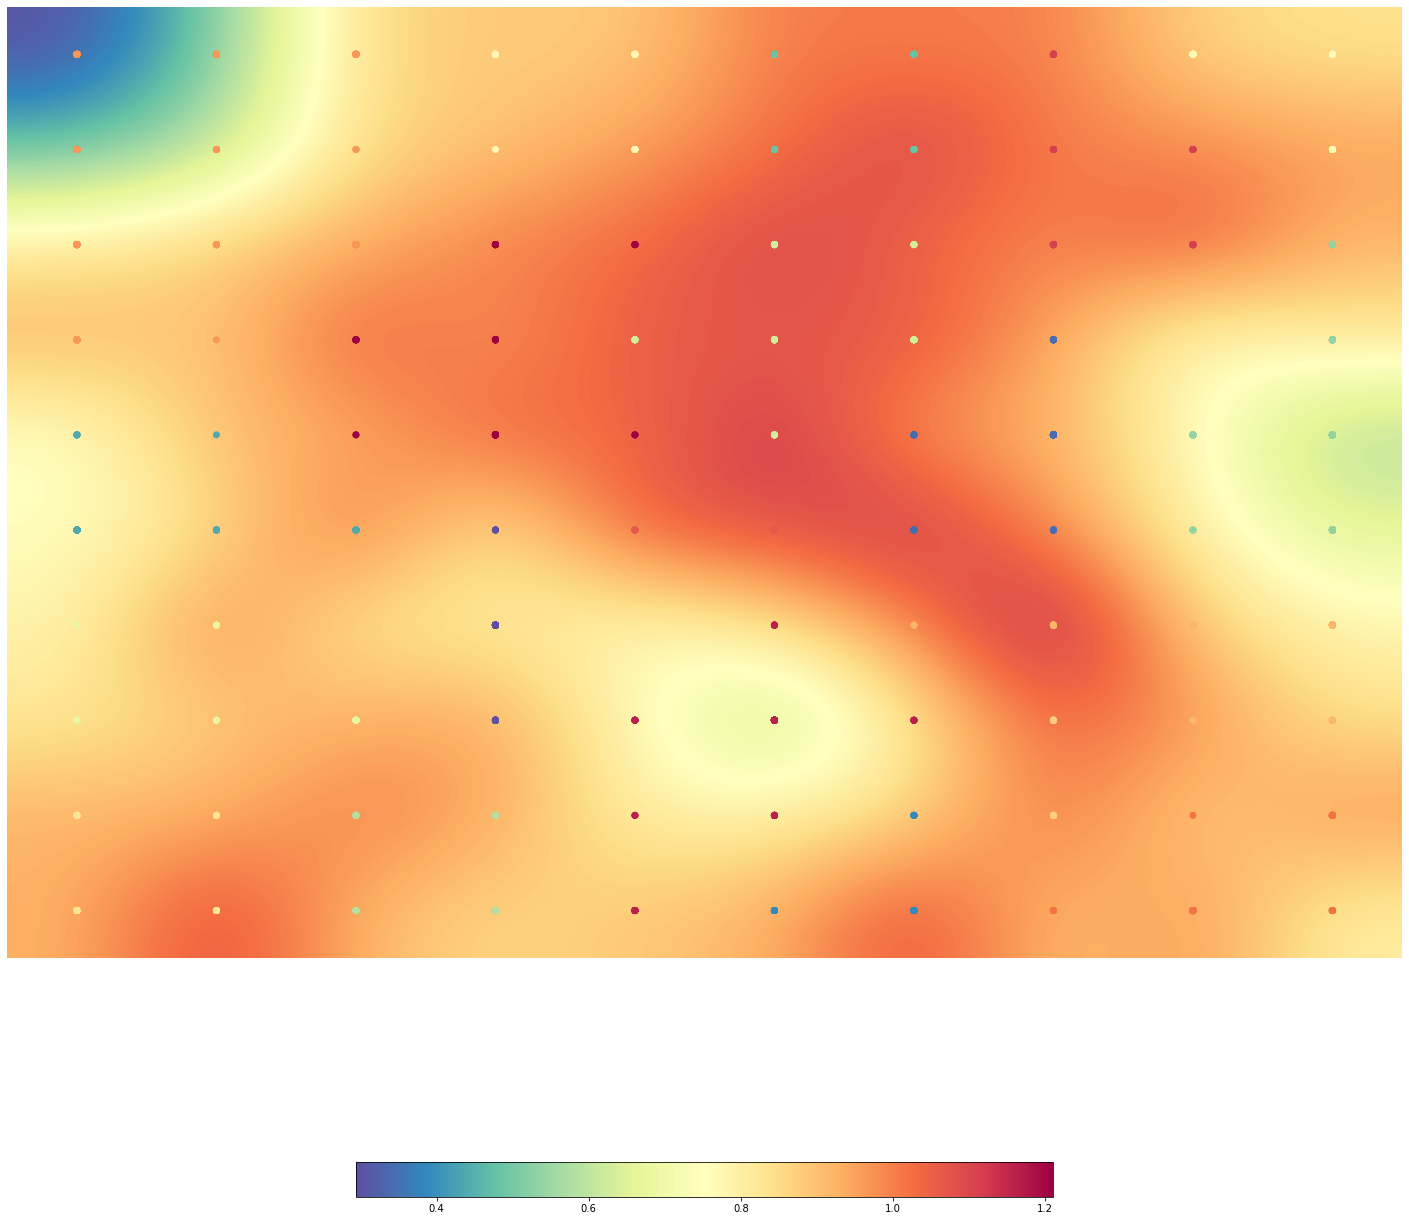

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

In [ ]:
som.view_umatrix(bestmatches = True, colorbar = True, figsize = (25, 25))

In [ ]:
clusters = som.clusters
print(clusters)

[[14 14 14 10 10  4  4 17  9  9]
 [14 14 14 10 10  4  4 17 17  9]
 [14 14 14 19 19  7  7 17 17  5]
 [14 14 19 19  7  7  7  1  5  5]
 [ 3  3 19 19 19  7  1  1  5  5]
 [ 3  3  3  0 16 16  1  1  5  5]
 [ 8  8  0  0  0 18 13 13 13 13]
 [ 8  8  8  0 18 18 18 12 13 13]
 [11 11  6  6 18 18  2 12 15 15]
 [11 11  6  6 18  2  2 15 15 15]]


In [ ]:
cl_id, cl_cnt = np.unique(som.clusters, return_counts = True)
cl_info = dict(zip(cl_id, cl_cnt))
cl_info_sorted = { k: v for k, v in sorted(cl_info.items(), key = lambda item: item[1]) }
print(cl_info_sorted)

{12: 2, 16: 2, 2: 3, 9: 3, 4: 4, 6: 4, 10: 4, 11: 4, 0: 5, 1: 5, 3: 5, 8: 5, 15: 5, 17: 5, 7: 6, 13: 6, 5: 7, 18: 7, 19: 7, 14: 11}



## Σημασιολογική ερμηνεία των clusters

Προκειμένου να μελετήσουμε τις τοπολογικές ιδιότητες του SOM και το αν έχουν ενσωματώσει σημασιολογική πληροφορία για τις ταινίες διαμέσου της διανυσματικής αναπαράστασης του tf-idf, των εμφυτευμάτων και των κατηγοριών, χρειαζόμαστε ένα κριτήριο ποιοτικής επισκόπησης των clusters. 

Θα υλοποιήσουμε το εξής κριτήριο: Λαμβάνουμε όρισμα έναν αριθμό (ετικέτα) cluster. Για το cluster αυτό βρίσκουμε όλους τους νευρώνες που του έχουν ανατεθεί από τον k-Means. Για όλους τους νευρώνες αυτούς βρίσκουμε όλες τις ταινίες που τους έχουν ανατεθεί (για τις οποίες αποτελούν bmus). Για όλες αυτές τις ταινίες τυπώνουμε ταξινομημένη τη συνολική στατιστική όλων των ειδών (κατηγοριών) και τις συχνότητές τους. Αν το cluster διαθέτει καλή συνοχή και εξειδίκευση, θα πρέπει κάποιες κατηγορίες να έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες. Θα μπορούμε τότε να αναθέσουμε αυτήν/ές την/τις κατηγορία/ες ως ετικέτες κινηματογραφικού είδους στο cluster.

Μπορείτε να υλοποιήσετε τη συνάρτηση αυτή όπως θέλετε. Μια πιθανή διαδικασία θα μπορούσε να είναι η ακόλουθη:

1. Ορίζουμε συνάρτηση `print_categories_stats` που δέχεται ως είσοδο λίστα με ids ταινιών. Δημιουργούμε μια κενή λίστα συνολικών κατηγοριών. Στη συνέχεια, για κάθε ταινία επεξεργαζόμαστε το string `categories` ως εξής: δημιουργούμε μια λίστα διαχωρίζοντας το string κατάλληλα με την `split` και αφαιρούμε τα whitespaces μεταξύ ετικετών με την `strip`. Προσθέτουμε τη λίστα αυτή στη συνολική λίστα κατηγοριών με την `extend`. Τέλος χρησιμοποιούμε πάλι την `np.unique` για να μετρήσουμε συχνότητα μοναδικών ετικετών κατηγοριών και ταξινομούμε με την `np.argsort`. Τυπώνουμε τις κατηγορίες και τις συχνότητες εμφάνισης ταξινομημένα. Χρήσιμες μπορεί να σας φανούν και οι `np.ravel`, `np.nditer`, `np.array2string` και `zip`.

2. Ορίζουμε τη βασική μας συνάρτηση `print_cluster_neurons_movies_report` που δέχεται ως όρισμα τον αριθμό ενός cluster. Με τη χρήση της `np.where` μπορούμε να βρούμε τις συντεταγμένες των bmus που αντιστοιχούν στο cluster και με την `column_stack` να φτιάξουμε έναν πίνακα bmus για το cluster. Προσοχή στη σειρά (στήλη - σειρά) στον πίνακα bmus. Για κάθε bmu αυτού του πίνακα ελέγχουμε αν υπάρχει στον πίνακα μοναδικών bmus που έχουμε υπολογίσει στην αρχή συνολικά και αν ναι προσθέτουμε το αντίστοιχο index του νευρώνα σε μια λίστα. Χρήσιμες μπορεί να είναι και οι `np.rollaxis`, `np.append`, `np.asscalar`. Επίσης πιθανώς να πρέπει να υλοποιήσετε ένα κριτήριο ομοιότητας μεταξύ ενός bmu και ενός μοναδικού bmu από τον αρχικό πίνακα bmus.

3. Υλοποιούμε μια βοηθητική συνάρτηση `neuron_movies_report`. Λαμβάνει ένα σύνολο νευρώνων από την `print_cluster_neurons_movies_report` και μέσω της `indices` φτιάχνει μια λίστα με το σύνολο ταινιών που ανήκουν σε αυτούς τους νευρώνες. Στο τέλος καλεί με αυτή τη λίστα την `print_categories_stats` που τυπώνει τις στατιστικές των κατηγοριών.

Μπορείτε βέβαια να προσθέσετε οποιαδήποτε επιπλέον έξοδο σας βοηθάει. Μια χρήσιμη έξοδος είναι πόσοι νευρώνες ανήκουν στο cluster και σε πόσους και ποιους από αυτούς έχουν ανατεθεί ταινίες.

Θα επιτελούμε τη σημασιολογική ερμηνεία του χάρτη καλώντας την `print_cluster_neurons_movies_report` με τον αριθμός ενός cluster που μας ενδιαφέρει. 

Παράδειγμα εξόδου για ένα cluster (μη βελτιστοποιημένος χάρτης, ωστόσο βλέπετε ότι οι μεγάλες κατηγορίες έχουν σημασιολογική  συνάφεια):

```
Overall Cluster Genres stats:  
[('"Horror"', 86), ('"Science Fiction"', 24), ('"B-movie"', 16), ('"Monster movie"', 10), ('"Creature Film"', 10), ('"Indie"', 9), ('"Zombie Film"', 9), ('"Slasher"', 8), ('"World cinema"', 8), ('"Sci-Fi Horror"', 7), ('"Natural horror films"', 6), ('"Supernatural"', 6), ('"Thriller"', 6), ('"Cult"', 5), ('"Black-and-white"', 5), ('"Japanese Movies"', 4), ('"Short Film"', 3), ('"Drama"', 3), ('"Psychological thriller"', 3), ('"Crime Fiction"', 3), ('"Monster"', 3), ('"Comedy"', 2), ('"Western"', 2), ('"Horror Comedy"', 2), ('"Archaeology"', 2), ('"Alien Film"', 2), ('"Teen"', 2), ('"Mystery"', 2), ('"Adventure"', 2), ('"Comedy film"', 2), ('"Combat Films"', 1), ('"Chinese Movies"', 1), ('"Action/Adventure"', 1), ('"Gothic Film"', 1), ('"Costume drama"', 1), ('"Disaster"', 1), ('"Docudrama"', 1), ('"Film adaptation"', 1), ('"Film noir"', 1), ('"Parody"', 1), ('"Period piece"', 1), ('"Action"', 1)]```
   

In [ ]:
def print_categories_stats(movies_ids):
    print("Number of movies in this cluster:", len(movies_ids))

    total_categories = {}
    for movie_id in movies_ids:
        for category in categories[movie_id][0].split(',  '):
            total_categories[category] = total_categories.get(category, 0) + 1
    
    print("Movie genres sorted by frequency for this cluster:")
    return [(k, v) for k, v in sorted(total_categories.items(), key = lambda item: item[1], reverse = True)]

def print_cluster_neurons_movies_report(cluster_id,clusters):
    ans_list = []
    clusters_coords = np.where(clusters == cluster_id)
    bmus_arr = np.column_stack((clusters_coords[0], clusters_coords[1]))
    # bmus_arr = np.column_stack((clusters_coords[1],clusters_coords[0]))
    print("Number of neurons in this cluster:", len(bmus_arr))
    for bmu_x, bmu_y in bmus_arr:
        if (bmu_x, bmu_y) in ubmus:
          ans_list.append(bmu_x * clusters.shape[0] + bmu_y)
    return ans_list

def neuron_movies_report(neurons):
  return([i for i, e in enumerate(indices) if e in neurons])

In [ ]:
for i in range(k):
    print("Cluster id:", i)
    print(print_categories_stats(neuron_movies_report(print_cluster_neurons_movies_report(i,clusters))))
    print('\n')

Cluster id: 0
Number of neurons in this cluster: 5
Number of movies in this cluster: 51
Movie genres sorted by frequency for this cluster:
[('"Action"', 47), ('"Action/Adventure"', 35), ('"Adventure"', 29), ('"Comedy"', 23), ('"Western"', 8), ('"Crime Fiction"', 6), ('"Fantasy"', 6), ('"War film"', 5), ('"Black-and-white"', 5), ('"Costume drama"', 4), ('"Horror"', 4), ('"Road movie"', 4), ('"Sports"', 3), ('"Historical fiction"', 3), ('"Romance Film"', 3), ('"Swashbuckler films"', 3), ('"Spy"', 3), ('"Science Fiction"', 3), ('"Adventure Comedy"', 3), ('"Sword and Sandal"', 2), ('"History"', 2), ('"Natural horror films"', 2), ('"Ensemble Film"', 2), ('"Disaster"', 2), ('"Television movie"', 2), ('"Anime"', 2), ('"Buddy film"', 2), ('"Chase Movie"', 2), ('"Crime Thriller"', 2), ('"Family Film"', 2), ('"Crime Comedy"', 2), ('"Comedy-drama"', 1), ('"Epic"', 1), ('"Historical Epic"', 1), ('"Documentary"', 1), ('"Biopic [feature]"', 1), ('"Biographical film"', 1), ('"Sci-Fi Adventure"', 1), 

### Δοκιμές

#### Για set με 2500 ταινίες

In [ ]:
f_set_2500 = build_final_set(corpus_tf_idf_new_pca, 2500)

##### Για χάρτη 20x20 με 100 epochs

In [ ]:
n_rows, n_columns = 20, 20
som_20x20_2500 = somoclu.Somoclu(n_columns, n_rows, compactsupport = False)
%time som_20x20_2500.train(f_set_2500, epochs = 100)

CPU times: user 5min 44s, sys: 1.64 s, total: 5min 46s
Wall time: 3min 15s


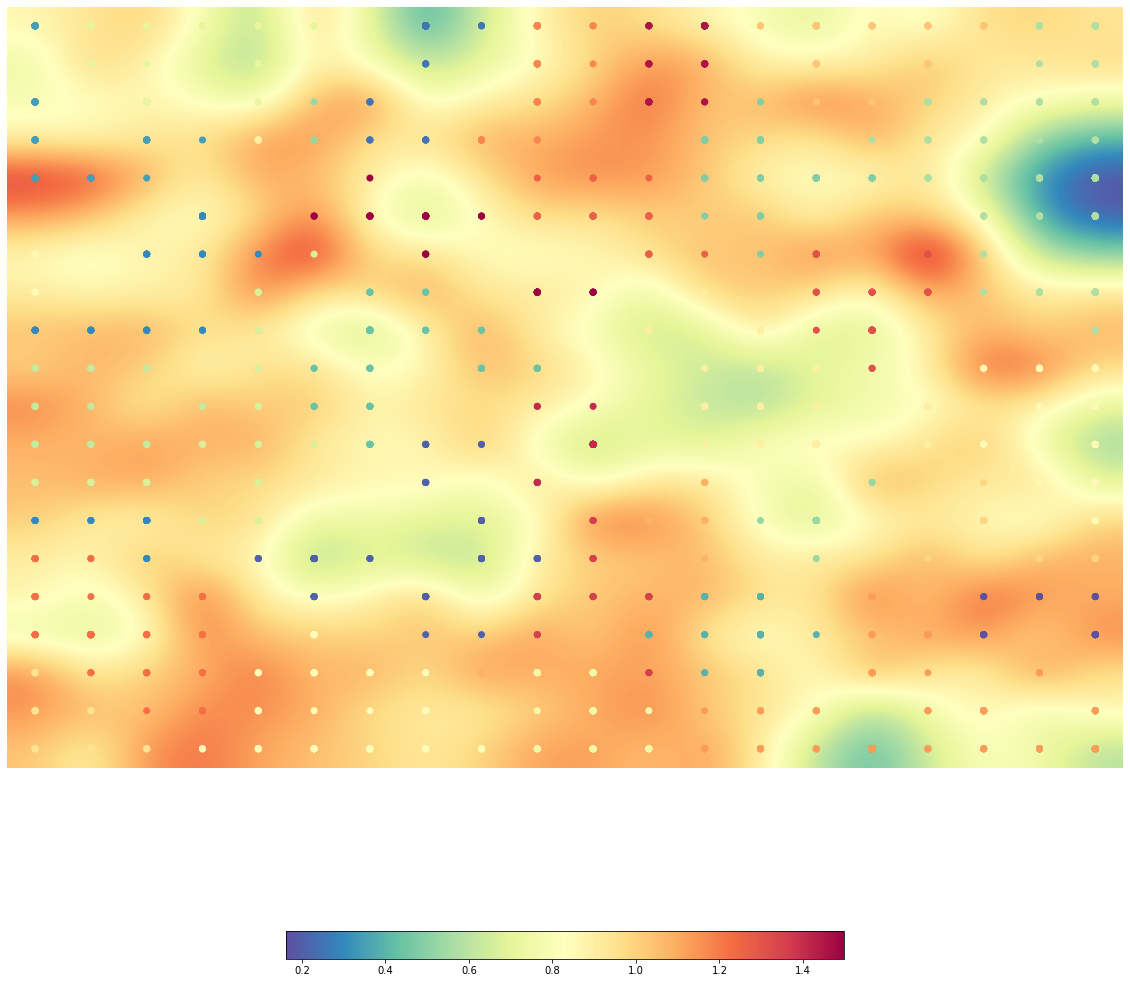

In [ ]:
k = 30
algorithm = KMeans(n_clusters = k)
som_20x20_2500.cluster(algorithm = algorithm)
som_20x20_2500.view_umatrix(bestmatches = True, colorbar = True, figsize = (20, 20))
clusters_20x20_30_2500 = som_20x20_2500.clusters

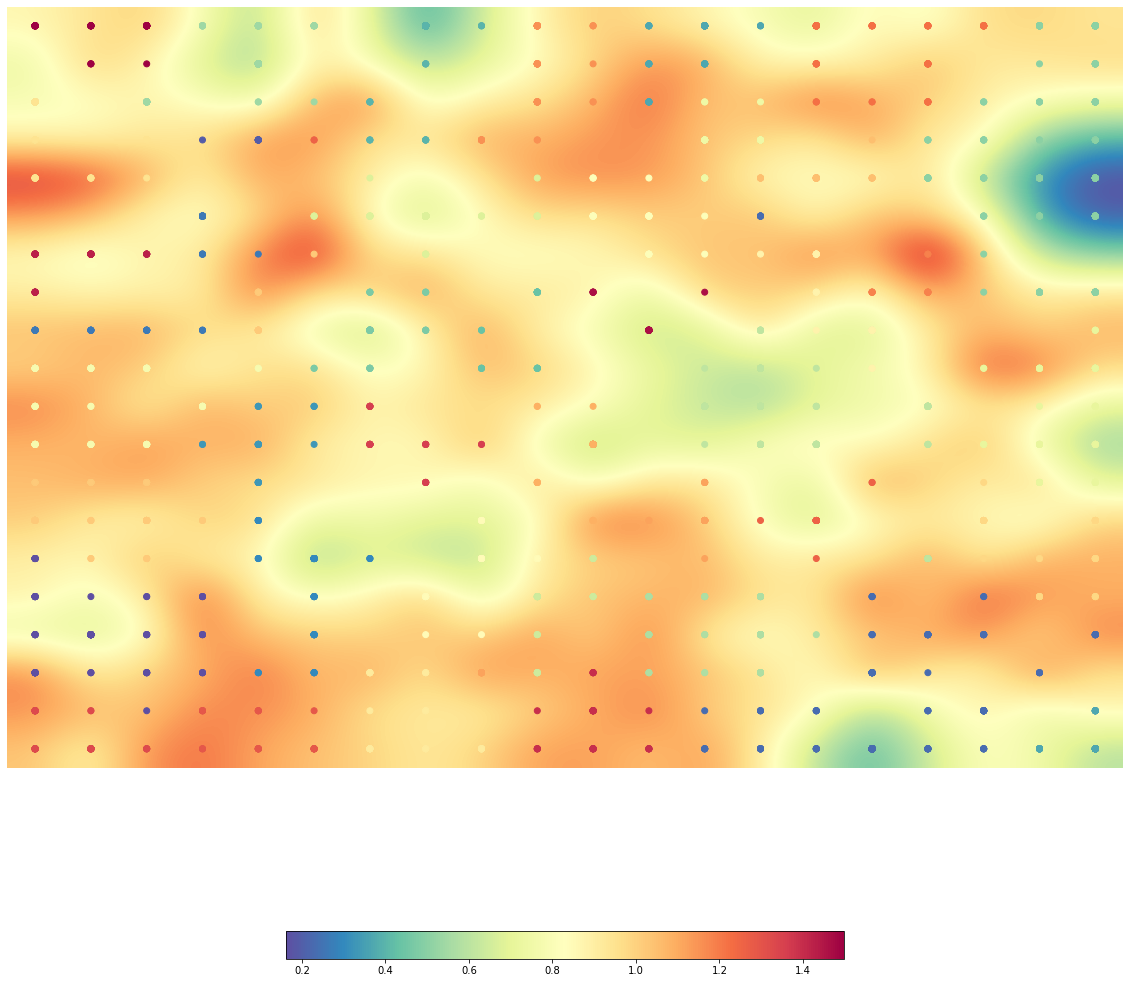

In [ ]:
k = 40
algorithm = KMeans(n_clusters = k)
som_20x20_2500.cluster(algorithm = algorithm)
som_20x20_2500.view_umatrix(bestmatches = True, colorbar = True, figsize = (20, 20))
clusters_20x20_40_2500 = som_20x20_2500.clusters

##### Για χάρτη 30x30 με 100 epochs

In [ ]:
n_rows, n_columns = 30, 30
som_30x30_2500 = somoclu.Somoclu(n_columns, n_rows, compactsupport = False)
%time som_30x30_2500.train(f_set_2500, epochs = 100)

CPU times: user 13min 1s, sys: 3.99 s, total: 13min 5s
Wall time: 6min 42s


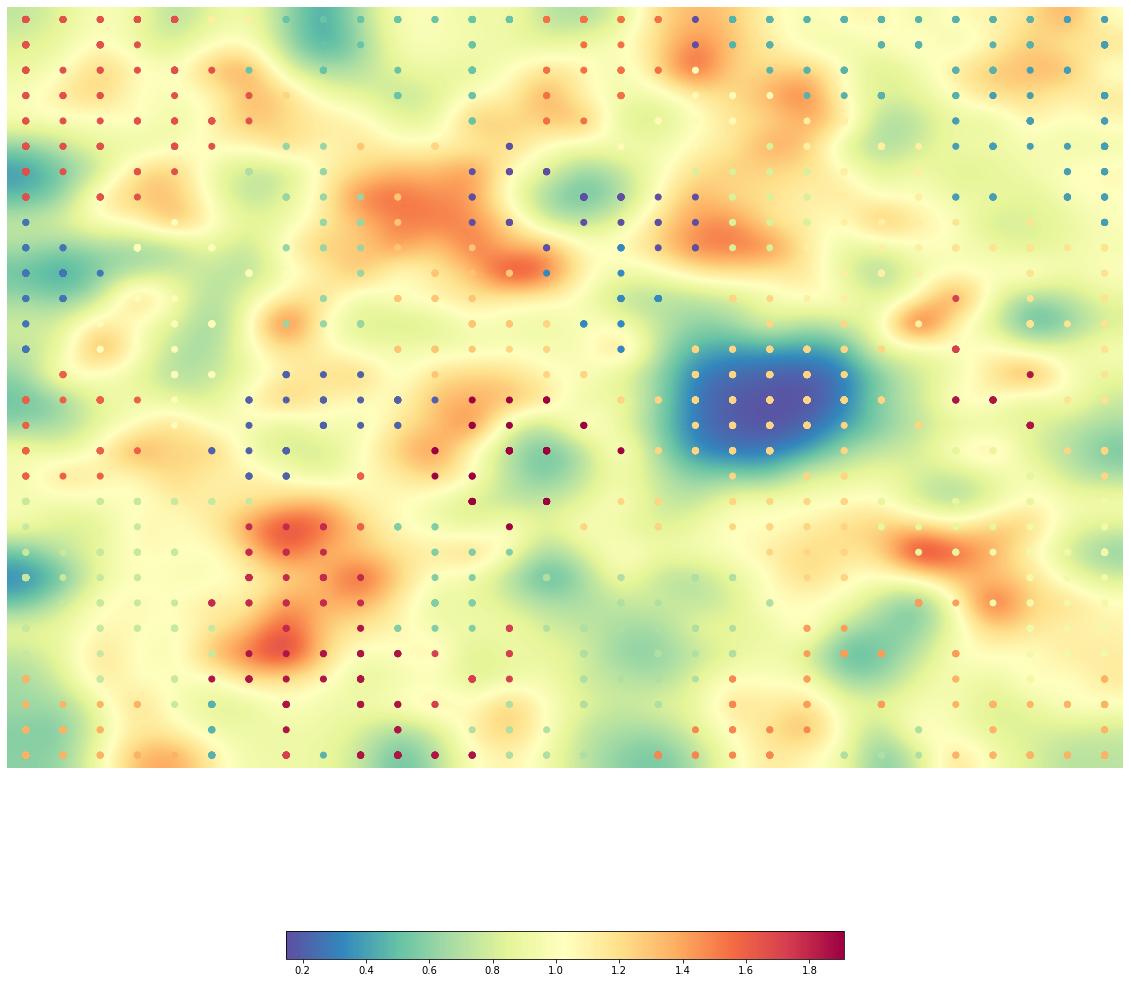

In [ ]:
k = 30
algorithm = KMeans(n_clusters = k)
som_30x30_2500.cluster(algorithm = algorithm)
som_30x30_2500.view_umatrix(bestmatches = True, colorbar = True, figsize = (20, 20))
clusters_30x30_30_2500 = som_30x30_2500.clusters

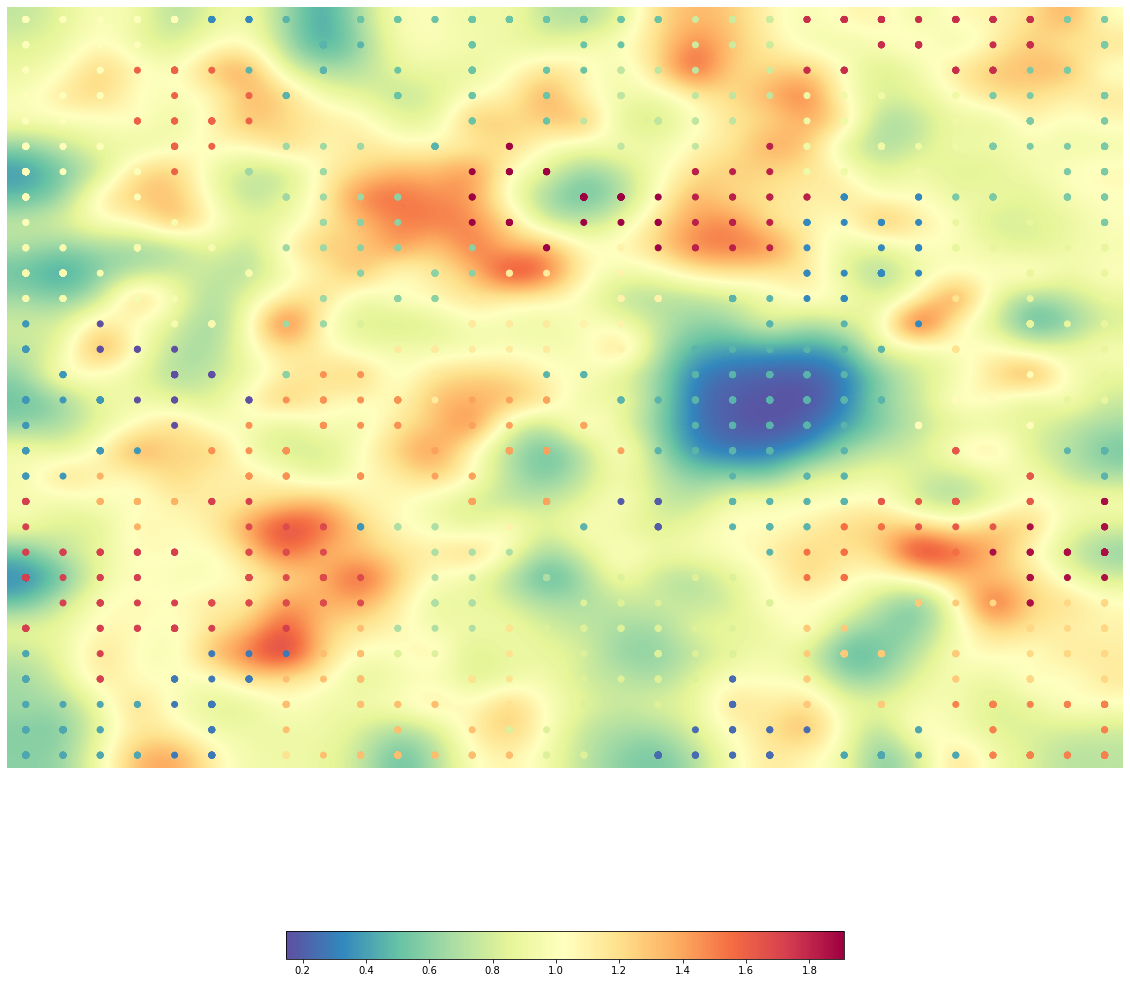

In [ ]:
k = 40
algorithm = KMeans(n_clusters = k)
som_30x30_2500.cluster(algorithm = algorithm)
som_30x30_2500.view_umatrix(bestmatches = True, colorbar = True, figsize = (20, 20))
clusters_30x30_40_2500 = som_30x30_2500.clusters

#### Για set με 5000 ταινίες

In [ ]:
f_set_5000 = build_final_set(corpus_tf_idf_new_pca, 5000)

##### Για χάρτη 20x20 με 100 epochs

In [ ]:
n_rows, n_columns = 20, 20
som_20x20_5000 = somoclu.Somoclu(n_columns, n_rows, compactsupport = False)
%time som_20x20_5000.train(f_set_5000, epochs = 100)

CPU times: user 11min 33s, sys: 2.79 s, total: 11min 36s
Wall time: 5min 55s


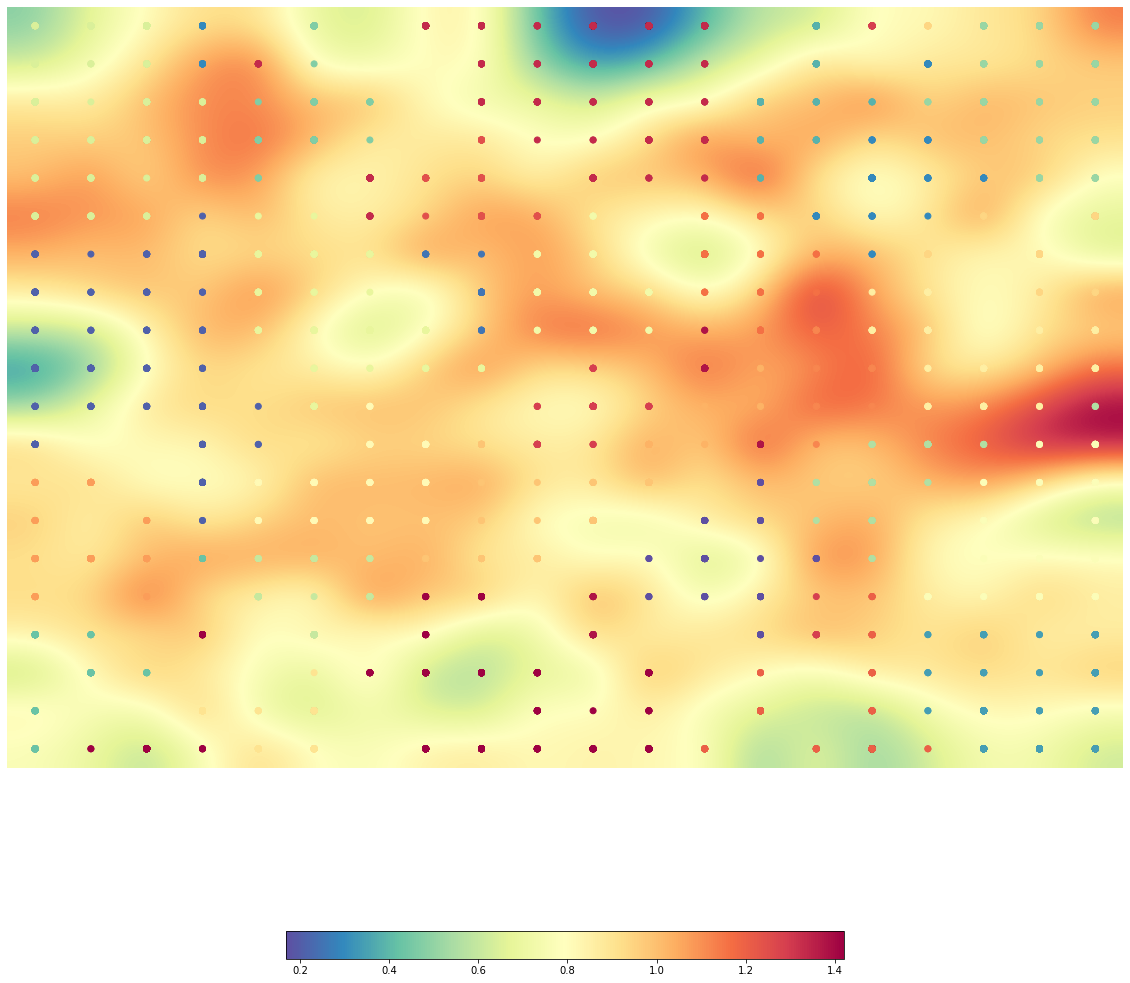

In [ ]:
k = 30
algorithm = KMeans(n_clusters = k)
som_20x20_5000.cluster(algorithm = algorithm)
som_20x20_5000.view_umatrix(bestmatches = True, colorbar = True, figsize = (20, 20))
clusters_20x20_30_5000 = som_20x20_5000.clusters

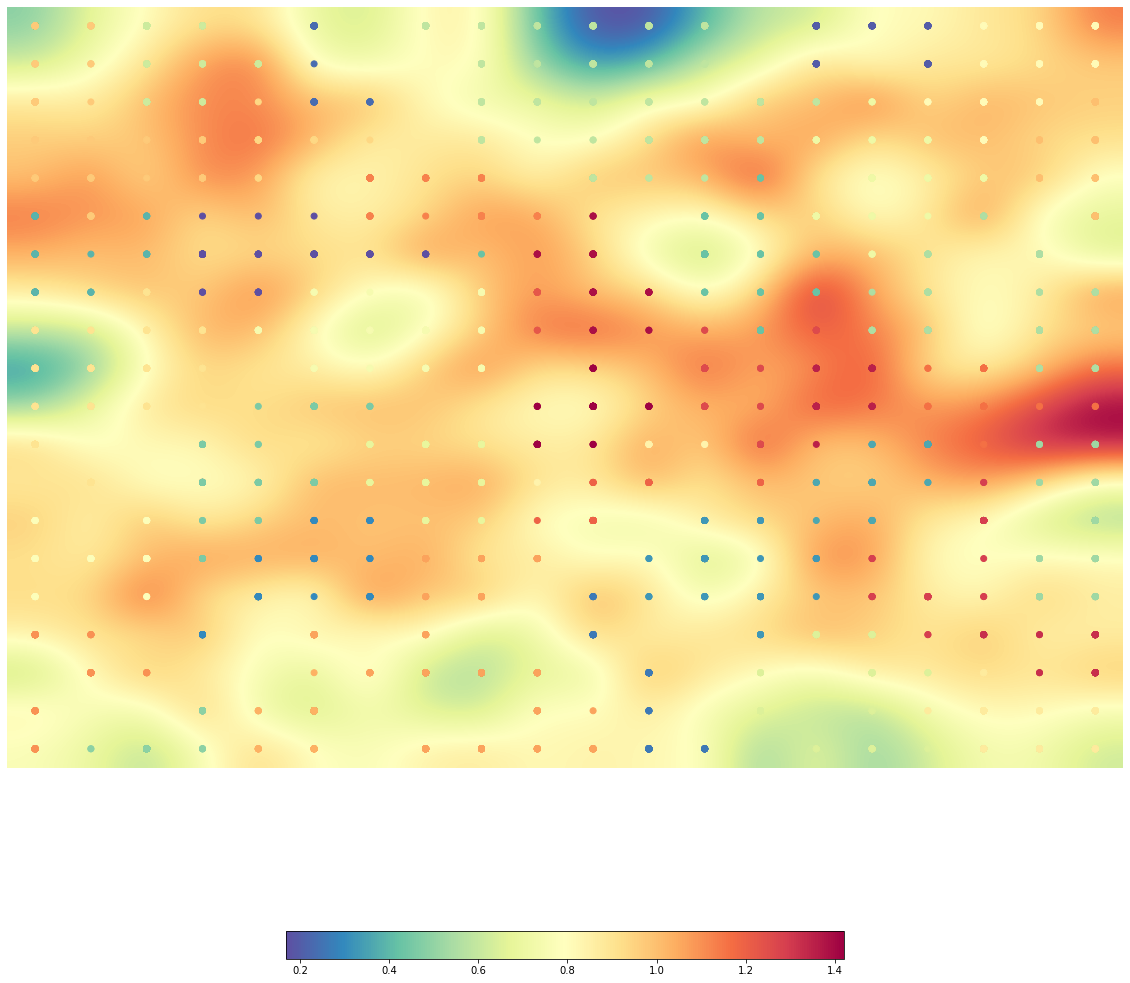

In [ ]:
k = 40
algorithm = KMeans(n_clusters = k)
som_20x20_5000.cluster(algorithm = algorithm)
som_20x20_5000.view_umatrix(bestmatches = True, colorbar = True, figsize = (20, 20))
clusters_20x20_40_5000 = som_20x20_5000.clusters

##### Για χάρτη 30x30 με 100 epochs

In [ ]:
n_rows, n_columns = 30, 30
som_30x30_5000 = somoclu.Somoclu(n_columns, n_rows, compactsupport = False)
%time som_30x30_5000.train(f_set_5000, epochs = 100)

CPU times: user 26min 21s, sys: 7.11 s, total: 26min 28s
Wall time: 13min 30s


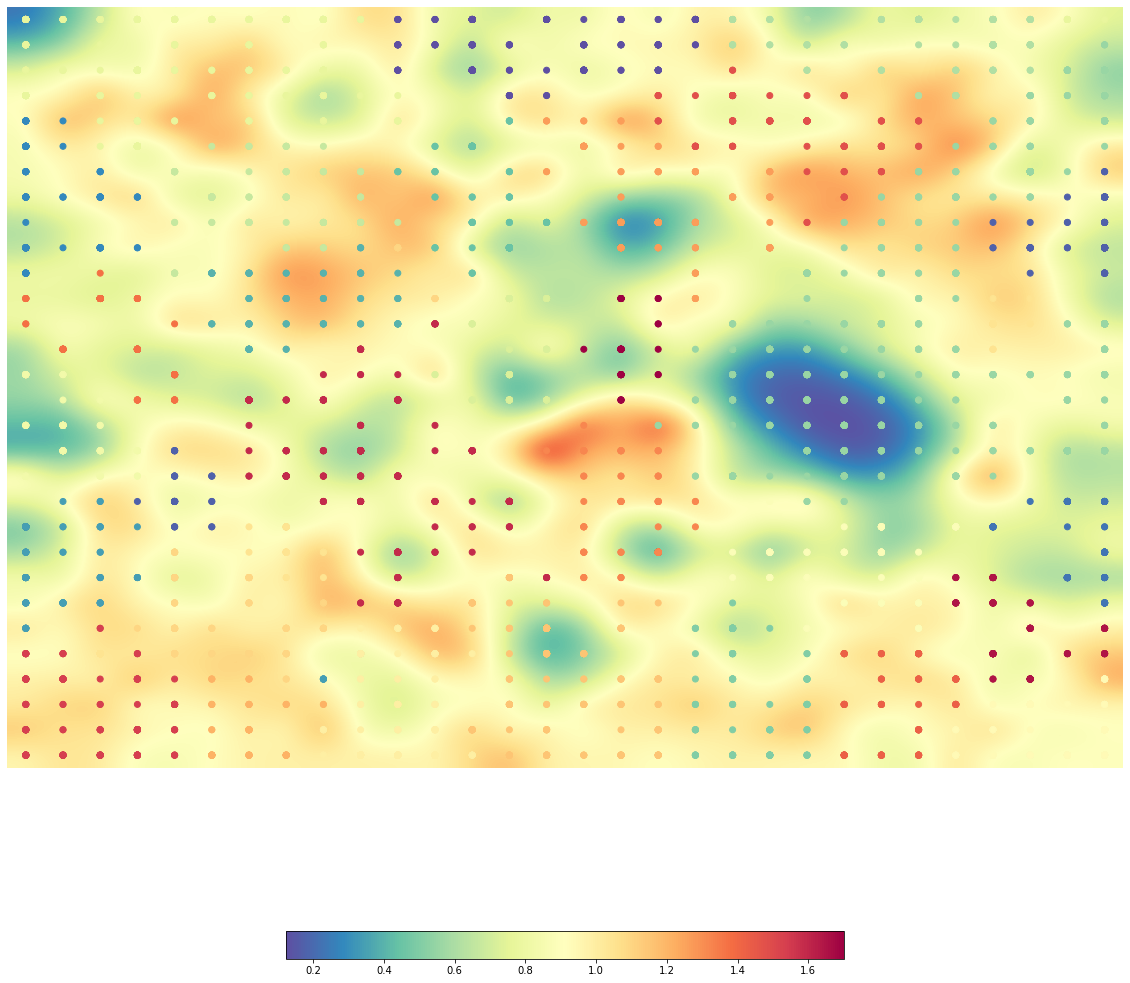

In [ ]:
k = 30
algorithm = KMeans(n_clusters = k)
som_30x30_5000.cluster(algorithm = algorithm)
som_30x30_5000.view_umatrix(bestmatches = True, colorbar = True, figsize = (20, 20))
clusters_30x30_30_5000 = som_30x30_5000.clusters

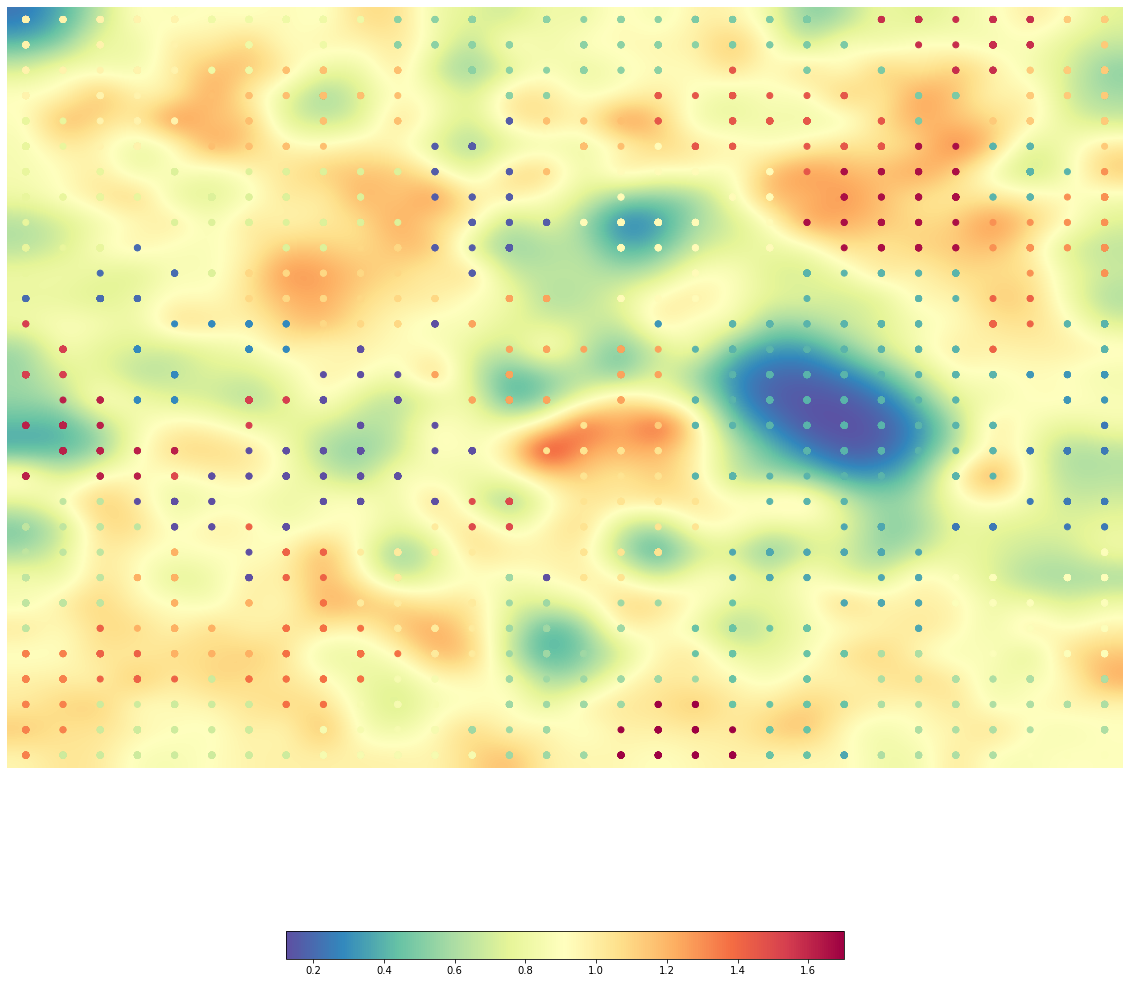

In [ ]:
k = 40
algorithm = KMeans(n_clusters = k)
som_30x30_5000.cluster(algorithm = algorithm)
som_30x30_5000.view_umatrix(bestmatches = True, colorbar = True, figsize = (20, 20))
clusters_30x30_40_5000 = som_30x30_5000.clusters

### Παρατηρήσεις

* Έγιναν δοκιμές για όλους τους συνδυασμούς των παρακάτω παραμέτρων:
 * 2500 και 5000 ταινίες
 * Μεγέθη χάρτη SOM 20x20 και 30x30
 * Τιμές k 30 και 40
* Αρχικά παρατηρούμε ότι ο χρόνος εκπαίδευσης αυξάνεται όσο αυξάνεται οποιαδήποτε από τις πιο πάνω παραμέτρους.
* Φαίνεται επίσης ότι γενικά τα αποτελέσματα είναι καλύτερα για 2500 ταινίες από ότι για 5000
* Για χάρτες ιδίου μεγέθους, φαίνεται από την οπτική αναπαράσταση ότι η διαφοροποιήση της τιμής του k κάνει τα χρώματα του χάρτη να φαίνονται πιο έντονα αλλά η μορφή του δεν αλλάζει
* Για 5000 ταινίες οι χάρτες 20x20 έχουν μεγάλες διαφορές με τους χάρτες 30x30
* Επιλέγουμε ως καλύτερο χάρτη για τις 5000 ταινίες το χάρτη 30x30 με k=40 αφού φαίνεται να είναι και ο χάρτης που διακρίνονται καλύτερα μπλε-πράσινες και κόκκινες περιοχές

### Κατηγορίες και τις συχνότητες εμφάνισης για το βέλτιστο χάρτη SOM

In [ ]:
k = 40
print(clusters_30x30_40_5000)
print('\n')
for i in range(k):
    print("Cluster id:", i)
    print(print_categories_stats(neuron_movies_report(print_cluster_neurons_movies_report(i,clusters_30x30_40_5000))))
    print('\n')

[[21 21 21 21 21 17 17 17 17 17 10 10 10 10 10 10 10 10  9  9  9  9  9 36
  36 36 36 36 25 25]
 [21 21 21 21 21 17 17 17 17 17 10 10 10 10 10 10 10 10 10  9  9  9  9  9
  36 36 36 36 25 25]
 [21 21 21 21 21 17 17 26 26 26 26 10 10 10 10 10 10 10 10 33  9  9  9  9
   9 36 36 25 25 25]
 [21 21 21 21 21 26 26 26 26 26 26 10 10 10 10 10 10 33 33 33 33 33 33  9
   9  9 25 25 25 25]
 [16 16 21 21 21 26 26 26 26 26 26 26  1  1 26 26 26 33 33 33 33 33 33 33
   9  9 25 25 25 25]
 [16 16 21 21 21 26 26 26 26 26 26  1  1  1 26 26 26 20 33 33 33 33 33 33
  38 38  7  7 25 25]
 [16 16 16 21 15 15 15 15 15 15 15  1  1  1 26 26 20 20 20 20 20 33 38 38
  38 38  7  7  7 29]
 [16 16 16 16 15 15 15 15 15 15 15  1  1  1  1 20 20 20 20 20 20 38 38 38
  38 38  7  7 29 29]
 [16 16 16 16 15 15 15 15 15 15 15  1  1  1  1 20 20 20 20 20 20 38 38 38
  38 38 29 29 29 29]
 [16 16 16  2  2 15 15 15 15 24 24  1  1  1  1 20 20 20 20 20 20  7 38 38
  38 38 29 29 29 29]
 [16  2  2  2  2 15 24 24 24 24 24 24  1  1  1 20 

### Κατηγορίες και τις συχνότητες εμφάνισης για ολόκληρο το dataset

In [ ]:
movie_array = [i for i in range(5000)]

print(print_categories_stats(movie_array))

Number of movies in this cluster: 5000
Movie genres sorted by frequency for this cluster:
[('"Drama"', 2313), ('"Comedy"', 1242), ('"Romance Film"', 813), ('"Thriller"', 803), ('"Action"', 704), ('"World cinema"', 580), ('"Crime Fiction"', 550), ('"Horror"', 517), ('"Black-and-white"', 422), ('"Indie"', 420), ('"Family Film"', 405), ('"Action/Adventure"', 405), ('"Short Film"', 398), ('"Adventure"', 366), ('"Musical"', 298), ('"Romantic drama"', 288), ('"Science Fiction"', 284), ('"Animation"', 275), ('"Mystery"', 271), ('"Romantic comedy"', 263), ('"Fantasy"', 217), ('"Comedy film"', 217), ('"Crime Thriller"', 217), ('"War film"', 171), ('"Film adaptation"', 148), ('"Period piece"', 145), ('"Psychological thriller"', 144), ('"Comedy-drama"', 144), ('"Silent film"', 142), ('"Japanese Movies"', 140), ('"Bollywood"', 132), ('"Documentary"', 128), ('"Chinese Movies"', 118), ('"Black comedy"', 104), ('"Western"', 102), ('"Children\'s/Family"', 94), ('"Television movie"', 94), ('"Family Dra

### Συνοπτική παρουσίαση αποτελεσμάτων κατηγοριοποίησης για το βέλτιστο χάρτη SOM για 5000 ταινίες

Ως βέλτιστος χάρτης επιλέχθηκε ο χάρτης 30x30 με k=40 διότι φαίνεται να είναι ο χάρτης που διαχωρίζει καλύτερα το επίπεδο σε μπλε και κόκκινες περιοχές. Από τα 40 clusters μόνο τα 8 περιέχουν νευρώνες στους οποίους έχουν ανατεθεί ταινίες. Τα cluster αυτά φαίνεται να έχουν καλή συνοχή αφού κάποιες κατηγορίες έχουν σαφώς μεγαλύτερη συχνότητα από τις υπόλοιπες όπως προκύπτει από τη συχνοτική ανάλυση. Πιο κάτω παρουσιάζονται μόνο οι κατηγορίες με μεγάλη συχνότητα για κάθε cluster. τα 8 clusters - ετικέτες κινηματογραφικού είδους που έχουν σχηματιστεί είναι συνοπτικά οι εξής:<br><br>

<!-- | **Cluster ID**   |**9**|**10**|**17**|**21**|**25**|**26**|**33**|**36**|
|-------------------|-----|------|------|------|------|------|------|------|
| **Movies in Cluster** | 205 | 318 | 323 | 581 | 203 | 140 | 9  | 221 |
| **Drama**             | 97  | 127 | 261 | 341 | 62  | -   | -  | 64  |
| **Action/Adventure**  | 78  | -   | -   | 46  | -   | -   | -  | -   |
| **Action**            | 62  | 109 | -   | 87  | -   | -   | -  | -   |
| **Thriller**          | 57  | 110 | -   | -   | 36  | 43  | 9  | -   |
| **Comedy**            | 47  | 93  | 125 | -   | -   | -   | -  | 190 |
| **Black-and-white**   | 45  | -   | -   | -   | -   | -   | -  | -   |
| **World cinema**      | 41  | -   | 90  | -   | -   | -   | -  | -   |
| **Adventure**         | 40  | -   | -   | -   | -   | -   | -  | -   |
| **Crime Fiction**     | 39  | 64  | -   | -   | 48  | -   | -  | -   |
| **Romance Film**      | -   | -   | 177 | 40  | -   | -   | -  | -   |
| **Family Film**       | -   | 80  | -   | -   | -   | -   | -  | -   |
| **Romantic drama**    | -   | -   | 76  | -   | -   | -   | -  | -   |
| **Indie**             | -   | -   | -   | 52  | -   | -   | -  | -   |
| **Romantic comedy**   | -   | -   | 52  | -   | -   | -   | -  | -   |
| **War Film**          | -   | -   | -   | 49  | -   | -   | -  | -   |
| **Documentary**       | -   | -   | -   | 43  | -   | -   | -  | -   |
| **Comedy film**       | -   | -   | -   | 43  | -   | -   | -  | -   |
| **Horror**            | -   | -   | -   | -   | 102 | -   | 9  | -   |
| **Science fiction**   | -   | -   | -   | -   | 42  | -   | 9  | -   |
| **Mystery**           | -   | -   | -   | -   | 34  | -   | -  | -   |
| **Short Film**        | -   | -   | -   | -   | -   | 89  | -  | -   |
| **Animation**         | -   | -   | -   | -   | -   | 33  | -  | -   | -->

|Cluster Id: 9 (Movies: 205)|Cluster Id: 10 (Movies: 318)|Cluster Id: 17 (Movies: 323)|Cluster Id: 21 (Movies: 581)|Cluster Id: 25 (Movies: 203)|Cluster Id: 26 (Movies: 140)|Cluster Id: 33 (Movies: 9)|Cluster Id: 36 (Movies: 221)|
|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|:---------------------|
|Drama 97              |Drama 127             |Drama 261             |Drama 341             |Horror 102            |Short Film 89         |Thriller 9            |Comedy 190            |
|Action/Adventure 78   |Thriller 110          |Romance Film 177      |Action 87             |Drama 62              |Thriller 43           |Science Fiction 9     |Drama 64              |
|Action 62             |Action 109            |Comedy 125            |Indie 52              |Crime Fiction 48      |Animation 33          |Horror 9              |                      |
|Thriller 57           |Comedy 93             |World cinema 90       |War film 49           |Science Fiction 42    |                      |                      |                      |
|Comedy 47             |Family Film 80        |Romantic drama 76     |Action/Adventure 46   |Thriller 36           |                      |                      |                      |
|Black-and-white 45    |Crime Fiction 64      |Romantic comedy 52    |Documentary 43        |Mystery 34            |                      |                      |                      |
|World cinema 41       |                      |                      |Comedy film 43        |                      |                      |                      |                      |
|Adventure 40          |                      |                      |Romance Film 40       |                      |                      |                      |                      |
|Crime Fiction 39      |                      |                      |                      |                      |                      |                      |                      |





### Συμπεράσματα για το βέλτιστο χάρτη SOM για 5000 ταινίες

* Οι πιο συχνές κατηγορίες ταινιών (drama και comedy) εμφανίζονται σε πολλά clusters 
* Υπάρχουν σπάνιες κατηγορίες (πχ Japanese Movies, Mockumentary) που δεν εμφανίζονται ως κύρια κατηγορία σε κανένα cluster. Αυτό οφείλεται στο γεγονός ότι υπάρχουν στο dataset λίγες ταινίες με αυτές τις κατηγορίες. Επομένως, δεν υπάρχει αρκετή πληροφορία για αυτές τις κατηγορίες στις περιγραφές ώστε να μπορεί να γίνει εξαγωγή του είδους από αυτές
* Υπάρχουν κατηγορίες που η περιγραφή τους δεν μπορεί να τις προσδιορίσει. Για παράδειγμα το ότι μία ταινία είναι black and white, δεν μπορεί να εξαχθεί από την περιγραφή της. 
* Από την τοποθέτηση των νευρώνων σε clusters στο χάρτη φαίνεται ότι clusters που έχουν ίδιες κύριες κατηγορίες βρίσκονται κοντά μεταξύ τους. Συγκεκριμένα, τα clusters με κύρια κατηγορία το drama βρίσκονται σε κοντινές περιοχές. 
* Κοντινές κατηγορίες βρίσκονται κοντά μεταξύ τους στο χάρτη. Τέτοια περίπτωση είναι οι κατηγορίες Action/Adventure και Action
* Από την άλλη, clusters με διαφορετικές κύριες κατηγορίες βρίσκονται μακριά μεταξύ τους για παράδειγμα οι κατηγορίες Romance Film και Horror. Στην περίπτωση που δύο διαφορετικές κατηγορίες φαίνονται να βρίσκονται σε διπλανές θέσεις, οι περιοχές αυτές είναι κόκκινες και κίτρινες στο χάρτη άρα και πάλι φαίνεται ότι υπάρχει μεγάλη απόσταση μεταξύ τους όπως στην περίπτωση των Comedy και Horror
* Υπάρχουν clusters με ασαφή χαρακτηριστικά και φαινομενικά ασύνδετες κατηγορίες. Τέτοιο είναι το cluster 26 (short-film, thriller, animation)
* Υπάρχουν clusters με πολύ κοντινά χαρακτηριστικά. Τέτοια είναι τα clusters 9 και 10 που βρίσκονται σε γειτονικές περιοχές
* Υπάρχουν μεγάλα clusters με σαφή χαρακτηριστικά που θα μπορούσαν να χαρακτηριστούν ως ετικέτες κινηματογραφικού είδους πχ. το 17 (Drama-Romance) και το 25 (Horror-Drama)


## Tips για το SOM και το clustering

- Για την ομαδοποίηση ένα U-matrix καλό είναι να εμφανίζει και μπλε-πράσινες περιοχές (clusters) και κόκκινες περιοχές (ορίων). Παρατηρήστε ποια σχέση υπάρχει μεταξύ αριθμού ταινιών στο final set, μεγέθους grid και ποιότητας U-matrix.
- Για το k του k-Means προσπαθήστε να προσεγγίζει σχετικά τα clusters του U-matrix (όπως είπαμε είναι διαφορετικοί μέθοδοι clustering). Μικρός αριθμός k δεν θα σέβεται τα όρια. Μεγάλος αριθμός θα δημιουργεί υπο-clusters εντός των clusters που φαίνονται στο U-matrix. Το τελευταίο δεν είναι απαραίτητα κακό, αλλά μεγαλώνει τον αριθμό clusters που πρέπει να αναλυθούν σημασιολογικά.
- Σε μικρούς χάρτες και με μικρά final sets δοκιμάστε διαφορετικές παραμέτρους για την εκπαίδευση του SOM. Σημειώστε τυχόν παραμέτρους που επηρεάζουν την ποιότητα του clustering για το dataset σας ώστε να τις εφαρμόσετε στους μεγάλους χάρτες.
- Κάποια τοπολογικά χαρακτηριστικά εμφανίζονται ήδη σε μικρούς χάρτες. Κάποια άλλα χρειάζονται μεγαλύτερους χάρτες. Δοκιμάστε μεγέθη 20x20, 25x25 ή και 30x30 και αντίστοιχη προσαρμογή των k. Όσο μεγαλώνουν οι χάρτες, μεγαλώνει η ανάλυση του χάρτη αλλά μεγαλώνει και ο αριθμός clusters που πρέπει να αναλυθούν.




## Ανάλυση τοπολογικών ιδιοτήτων χάρτη SOM

Μετά το πέρας της εκπαίδευσης και του clustering θα έχετε ένα χάρτη με τοπολογικές ιδιότητες ως προς τα είδη των ταίνιών της συλλογής σας, κάτι αντίστοιχο με την εικόνα στην αρχή της Εφαρμογής 2 αυτού του notebook. Η συγκεκριμένη εικόνα είναι μόνο για εικονογράφιση, δεν είναι χάρτης SOM καιδεν έχει καμία σχέση με τη συλλογή δεδομένων και τις κατηγορίες μας.

Για τον τελικό χάρτη SOM που θα παράξετε για τη συλλογή σας, αναλύστε σε markdown με συγκεκριμένη αναφορά σε αριθμούς clusters και τη σημασιολογική ερμηνεία τους τις εξής τρεις τοπολογικές ιδιότητες του SOM: 

1. Δεδομένα που έχουν μεγαλύτερη πυκνότητα πιθανότητας στο χώρο εισόδου τείνουν να απεικονίζονται με περισσότερους νευρώνες στο χώρο μειωμένης διαστατικότητας. Δώστε παραδείγματα από συχνές και λιγότερο συχνές κατηγορίες ταινιών. Χρησιμοποιήστε τις στατιστικές των κατηγοριών στη συλλογή σας και τον αριθμό κόμβων που χαρακτηρίζουν.
2. Μακρινά πρότυπα εισόδου τείνουν να απεικονίζονται απομακρυσμένα στο χάρτη. Υπάρχουν χαρακτηριστικές κατηγορίες ταινιών που ήδη από μικρούς χάρτες τείνουν να τοποθετούνται σε διαφορετικά ή απομονωμένα σημεία του χάρτη.
3. Κοντινά πρότυπα εισόδου τείνουν να απεικονίζονται κοντά στο χάρτη. Σε μεγάλους χάρτες εντοπίστε είδη ταινιών και κοντινά τους υποείδη.

Προφανώς τοποθέτηση σε 2 διαστάσεις που να σέβεται μια απόλυτη τοπολογία δεν είναι εφικτή, αφενός γιατί δεν υπάρχει κάποια απόλυτη εξ ορισμού για τα κινηματογραφικά είδη ακόμα και σε πολλές διαστάσεις, αφετέρου γιατί πραγματοποιούμε μείωση διαστατικότητας.

Εντοπίστε μεγάλα clusters και μικρά clusters που δεν έχουν σαφή χαρακτηριστικά. Εντοπίστε clusters συγκεκριμένων ειδών που μοιάζουν να μην έχουν τοπολογική συνάφεια με γύρω περιοχές. Προτείνετε πιθανές ερμηνείες.


Τέλος, εντοπίστε clusters που έχουν κατά την άποψή σας ιδιαίτερο ενδιαφέρον στη συλλογή της ομάδας σας (data exploration / discovery value) και σχολιάστε.



# Τελική παράδοση άσκησης

- Θα παραδώσετε στο helios το παρόν notebook επεξεργασμένο ή ένα ή δύο νέα zipαρισμένα με τις απαντήσεις σας για τα ζητούμενα και των δύο εφαρμογών. 
- Θυμηθείτε ότι η ανάλυση του χάρτη στο markdown με αναφορά σε αριθμούς clusters πρέπει να αναφέρεται στον τελικό χάρτη με τα κελιά ορατά που θα παραδώσετε αλλιώς ο χάρτης που θα προκύψει θα είναι διαφορετικός και τα labels των clusters δεν θα αντιστοιχούν στην ανάλυσή σας. 
- Μην ξεχάσετε στην αρχή ένα κελί markdown με **τα στοιχεία της ομάδας σας**.

<table>
  <tr><td align="center">
    <font size="4">Παρακαλούμε διατρέξτε βήμα-βήμα το notebook για να μην ξεχάσετε παραδοτέα</font>
</td>
  </tr>
</table>